# Exploring southeast Alaskan climate data from the Weather Research and Forecasting (WRF) model, 1980-2019

For this activity, you will extract climate records from WRF and Climate Forecast System Reanalysis (CFSR) data at 4km spatial resolution over specific regions in southeast Alaska. See additional documentation here: https://registry.opendata.aws/wrf-se-alaska-snap/

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import os
import subprocess
import datetime

# to load satellite imagery:
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from urllib.request import urlopen, Request
from PIL import Image
import io

# grab cartopy imagery
def image_spoof(self, tile): # this function pretends not to be a Python script
    url = self._image_url(tile) # get the url of the street map API
    req = Request(url) # start request
    req.add_header('User-agent','Anaconda 3') # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read()) # get image
    fh.close() # close url
    img = Image.open(im_data) # open image with PIL
    img = img.convert(self.desired_tile_form) # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

# For instructors only:

#### Install AWS Command Line Interface

Instructions for AWS Command Line Interface (CLI) installation: https://docs.aws.amazon.com/cli/latest/userguide/getting-started-install.html

In [23]:
# browse the data files for 1980 here
!aws s3 ls --no-sign-request s3://wrf-se-ak-ar5/cfsr/4km/hourly/1980/

2020-11-25 17:03:04  691849360 WRFDS_1980-01-01.nc
2020-11-25 17:03:05  691849360 WRFDS_1980-01-02.nc
2020-11-25 17:03:07  691849360 WRFDS_1980-01-03.nc
2020-11-25 17:03:08  691849360 WRFDS_1980-01-04.nc
2020-11-25 17:03:08  691849360 WRFDS_1980-01-05.nc
2020-11-25 17:05:04  691849360 WRFDS_1980-01-06.nc
2020-11-25 17:05:05  691849360 WRFDS_1980-01-07.nc
2020-11-25 17:05:08  691849360 WRFDS_1980-01-08.nc
2020-11-25 17:05:08  691849360 WRFDS_1980-01-09.nc
2020-11-25 17:05:08  691849360 WRFDS_1980-01-10.nc
2020-11-25 17:07:12  691849360 WRFDS_1980-01-11.nc
2020-11-25 17:07:13  691849360 WRFDS_1980-01-12.nc
2020-11-25 17:07:15  691849360 WRFDS_1980-01-13.nc
2020-11-25 17:07:16  691849360 WRFDS_1980-01-14.nc
2020-11-25 17:07:16  691849360 WRFDS_1980-01-15.nc
2020-11-25 17:09:13  691849360 WRFDS_1980-01-16.nc
2020-11-25 17:09:15  691849360 WRFDS_1980-01-17.nc
2020-11-25 17:09:18  691849360 WRFDS_1980-01-18.nc
2020-11-25 17:09:19  691849360 WRFDS_1980-01-19.nc
2020-11-25 17:09:19  691849360 

2020-11-25 18:39:00  691849360 WRFDS_1980-08-27.nc
2020-11-25 18:39:00  691849360 WRFDS_1980-08-28.nc
2020-11-25 18:40:54  691849360 WRFDS_1980-08-29.nc
2020-11-25 18:40:55  691849360 WRFDS_1980-08-30.nc
2020-11-25 18:40:58  691849360 WRFDS_1980-08-31.nc
2020-11-25 18:40:58  691849360 WRFDS_1980-09-01.nc
2020-11-25 18:40:58  691849360 WRFDS_1980-09-02.nc
2020-11-25 18:42:52  691849360 WRFDS_1980-09-03.nc
2020-11-25 18:42:53  691849360 WRFDS_1980-09-04.nc
2020-11-25 18:42:56  691849360 WRFDS_1980-09-05.nc
2020-11-25 18:42:56  691849360 WRFDS_1980-09-06.nc
2020-11-25 18:42:57  691849360 WRFDS_1980-09-07.nc
2020-11-25 18:44:53  691849360 WRFDS_1980-09-08.nc
2020-11-25 18:44:54  691849360 WRFDS_1980-09-09.nc
2020-11-25 18:44:58  691849360 WRFDS_1980-09-10.nc
2020-11-25 18:44:58  691849360 WRFDS_1980-09-11.nc
2020-11-25 18:44:58  691849360 WRFDS_1980-09-12.nc
2020-11-25 18:46:59  691849360 WRFDS_1980-09-13.nc
2020-11-25 18:46:59  691849360 WRFDS_1980-09-14.nc
2020-11-25 18:47:03  691849360 

#### Download daily data files

In [5]:
# set up download folder somewhere on a shared drive for the students
download_path = '/Users/jukesliu/Documents/Downloads/' # change this path 
#to somewhere on the shared drive
if not os.path.exists(download_path):
    os.mkdir(download_path) # make the folder if it doesn't already exist

In [17]:
years = np.arange(1980,2020) # loop through all years 

for year in years: 
    # grab list of images in each year, path, row folder
    find_files = 'aws s3 ls --no-sign-request s3://wrf-se-ak-ar5/cfsr/4km/daily/'+str(year)+'/'
    
    if subprocess.run(find_files,shell=True).returncode != 0:
        print('No results found for s3://wrf-se-ak-ar5/cfsr/4km/daily/'+str(year))
        results = [] # empty results
    else:
        result = subprocess.check_output(find_files,shell=True) # grab the avilable images
        results = result.split() # split string
    
    for item in results:
        if 'WRFDS' in str(item):
            filename = str(item)[2:-1] # grab filename
            
            # download file command
            download_cmd = 'aws s3 cp --no-sign-request s3://wrf-se-ak-ar5/cfsr/4km/daily/'+str(year)+'/'+filename
            download_cmd += ' '+download_path+filename
            
            if not os.path.exists(download_path+filename): # if the file does not exist here
                subprocess.call(download_cmd, shell=True) # download it

2020-11-25 13:31:27   16440337 WRFDS_1980-01-01.nc
2020-11-25 13:31:27   16658124 WRFDS_1980-01-02.nc
2020-11-25 13:31:27   16384850 WRFDS_1980-01-03.nc
2020-11-25 13:31:27   16163678 WRFDS_1980-01-04.nc
2020-11-25 13:31:27   16641272 WRFDS_1980-01-05.nc
2020-11-25 13:31:27   16593252 WRFDS_1980-01-06.nc
2020-11-25 13:31:30   16224749 WRFDS_1980-01-07.nc
2020-11-25 13:31:30   16146380 WRFDS_1980-01-08.nc
2020-11-25 13:31:30   16190135 WRFDS_1980-01-09.nc
2020-11-25 13:31:32   16267889 WRFDS_1980-01-10.nc
2020-11-25 13:31:32   16171912 WRFDS_1980-01-11.nc
2020-11-25 13:31:32   16600923 WRFDS_1980-01-12.nc
2020-11-25 13:31:34   16521636 WRFDS_1980-01-13.nc
2020-11-25 13:31:35   16333452 WRFDS_1980-01-14.nc
2020-11-25 13:31:38   16322245 WRFDS_1980-01-15.nc
2020-11-25 13:31:38   16303401 WRFDS_1980-01-16.nc
2020-11-25 13:31:38   16626135 WRFDS_1980-01-17.nc
2020-11-25 13:31:38   16661466 WRFDS_1980-01-18.nc
2020-11-25 13:31:39   16819687 WRFDS_1980-01-19.nc
2020-11-25 13:31:43   16817100 

2020-11-25 13:37:15   16796443 WRFDS_1981-01-01.nc
2020-11-25 13:37:15   16901460 WRFDS_1981-01-02.nc
2020-11-25 13:37:16   16783372 WRFDS_1981-01-03.nc
2020-11-25 13:37:18   16703396 WRFDS_1981-01-04.nc
2020-11-25 13:37:19   16953755 WRFDS_1981-01-05.nc
2020-11-25 13:37:19   16948966 WRFDS_1981-01-06.nc
2020-11-25 13:37:19   16852683 WRFDS_1981-01-07.nc
2020-11-25 13:37:21   16956710 WRFDS_1981-01-08.nc
2020-11-25 13:37:23   16866408 WRFDS_1981-01-09.nc
2020-11-25 13:37:25   17039653 WRFDS_1981-01-10.nc
2020-11-25 13:37:25   17007719 WRFDS_1981-01-11.nc
2020-11-25 13:37:25   16939326 WRFDS_1981-01-12.nc
2020-11-25 13:37:26   16836292 WRFDS_1981-01-13.nc
2020-11-25 13:37:27   16931582 WRFDS_1981-01-14.nc
2020-11-25 13:37:29   16899403 WRFDS_1981-01-15.nc
2020-11-25 13:37:29   16924265 WRFDS_1981-01-16.nc
2020-11-25 13:37:29   16806978 WRFDS_1981-01-17.nc
2020-11-25 13:37:31   17046526 WRFDS_1981-01-18.nc
2020-11-25 13:37:32   17220129 WRFDS_1981-01-19.nc
2020-11-25 13:37:35   17024187 

2020-11-25 13:43:08   16454630 WRFDS_1982-01-01.nc
2020-11-25 13:43:08   16378335 WRFDS_1982-01-02.nc
2020-11-25 13:43:09   16294600 WRFDS_1982-01-03.nc
2020-11-25 13:43:09   16451578 WRFDS_1982-01-04.nc
2020-11-25 13:43:13   16892072 WRFDS_1982-01-05.nc
2020-11-25 13:43:13   16739190 WRFDS_1982-01-06.nc
2020-11-25 13:43:13   16569504 WRFDS_1982-01-07.nc
2020-11-25 13:43:13   16519652 WRFDS_1982-01-08.nc
2020-11-25 13:43:14   16814509 WRFDS_1982-01-09.nc
2020-11-25 13:43:18   17005598 WRFDS_1982-01-10.nc
2020-11-25 13:43:18   16882178 WRFDS_1982-01-11.nc
2020-11-25 13:43:18   16734191 WRFDS_1982-01-12.nc
2020-11-25 13:43:19   16788403 WRFDS_1982-01-13.nc
2020-11-25 13:43:19   16803505 WRFDS_1982-01-14.nc
2020-11-25 13:43:22   16763500 WRFDS_1982-01-15.nc
2020-11-25 13:43:22   16933653 WRFDS_1982-01-16.nc
2020-11-25 13:43:22   16635965 WRFDS_1982-01-17.nc
2020-11-25 13:43:23   16390264 WRFDS_1982-01-18.nc
2020-11-25 13:43:24   16569021 WRFDS_1982-01-19.nc
2020-11-25 13:43:26   16380817 

2020-11-25 13:48:44   16742799 WRFDS_1983-01-01.nc
2020-11-25 13:48:48   16906340 WRFDS_1983-01-02.nc
2020-11-25 13:48:49   16889983 WRFDS_1983-01-03.nc
2020-11-25 13:48:49   16775490 WRFDS_1983-01-04.nc
2020-11-25 13:48:49   16804062 WRFDS_1983-01-05.nc
2020-11-25 13:48:49   16800194 WRFDS_1983-01-06.nc
2020-11-25 13:48:53   16953863 WRFDS_1983-01-07.nc
2020-11-25 13:48:53   16875284 WRFDS_1983-01-08.nc
2020-11-25 13:48:53   16708371 WRFDS_1983-01-09.nc
2020-11-25 13:48:53   16831483 WRFDS_1983-01-10.nc
2020-11-25 13:48:53   16973666 WRFDS_1983-01-11.nc
2020-11-25 13:48:57   16929105 WRFDS_1983-01-12.nc
2020-11-25 13:48:57   16979838 WRFDS_1983-01-13.nc
2020-11-25 13:48:57   16945558 WRFDS_1983-01-14.nc
2020-11-25 13:48:58   16874929 WRFDS_1983-01-15.nc
2020-11-25 13:48:58   16866052 WRFDS_1983-01-16.nc
2020-11-25 13:49:02   16879932 WRFDS_1983-01-17.nc
2020-11-25 13:49:02   16885584 WRFDS_1983-01-18.nc
2020-11-25 13:49:02   16962984 WRFDS_1983-01-19.nc
2020-11-25 13:49:03   16635916 

2020-11-25 13:54:22   16917409 WRFDS_1984-01-01.nc
2020-11-25 13:54:22   16779154 WRFDS_1984-01-02.nc
2020-11-25 13:54:22   16931358 WRFDS_1984-01-03.nc
2020-11-25 13:54:22   16928124 WRFDS_1984-01-04.nc
2020-11-25 13:54:24   16916678 WRFDS_1984-01-05.nc
2020-11-25 13:54:25   16613831 WRFDS_1984-01-06.nc
2020-11-25 13:54:25   16524217 WRFDS_1984-01-07.nc
2020-11-25 13:54:26   16388189 WRFDS_1984-01-08.nc
2020-11-25 13:54:26   16655706 WRFDS_1984-01-09.nc
2020-11-25 13:54:27   16835723 WRFDS_1984-01-10.nc
2020-11-25 13:54:28   16897630 WRFDS_1984-01-11.nc
2020-11-25 13:54:28   16830710 WRFDS_1984-01-12.nc
2020-11-25 13:54:28   16882294 WRFDS_1984-01-13.nc
2020-11-25 13:54:28   16830805 WRFDS_1984-01-14.nc
2020-11-25 13:54:31   16593909 WRFDS_1984-01-15.nc
2020-11-25 13:54:32   16320905 WRFDS_1984-01-16.nc
2020-11-25 13:54:32   16596435 WRFDS_1984-01-17.nc
2020-11-25 13:54:32   16843065 WRFDS_1984-01-18.nc
2020-11-25 13:54:32   17017343 WRFDS_1984-01-19.nc
2020-11-25 13:54:34   16779260 

2020-11-25 13:59:12   17002460 WRFDS_1985-01-01.nc
2020-11-25 13:59:17   17115608 WRFDS_1985-01-02.nc
2020-11-25 13:59:17   16962554 WRFDS_1985-01-03.nc
2020-11-25 13:59:17   16925175 WRFDS_1985-01-04.nc
2020-11-25 13:59:17   17011012 WRFDS_1985-01-05.nc
2020-11-25 13:59:17   16892904 WRFDS_1985-01-06.nc
2020-11-25 13:59:20   16902247 WRFDS_1985-01-07.nc
2020-11-25 13:59:20   16894224 WRFDS_1985-01-08.nc
2020-11-25 13:59:20   17045477 WRFDS_1985-01-09.nc
2020-11-25 13:59:21   16806380 WRFDS_1985-01-10.nc
2020-11-25 13:59:21   17001085 WRFDS_1985-01-11.nc
2020-11-25 13:59:25   16912671 WRFDS_1985-01-12.nc
2020-11-25 13:59:25   16916216 WRFDS_1985-01-13.nc
2020-11-25 13:59:25   16754888 WRFDS_1985-01-14.nc
2020-11-25 13:59:27   16812072 WRFDS_1985-01-15.nc
2020-11-25 13:59:27   16697944 WRFDS_1985-01-16.nc
2020-11-25 13:59:30   17096447 WRFDS_1985-01-17.nc
2020-11-25 13:59:31   16913062 WRFDS_1985-01-18.nc
2020-11-25 13:59:31   16855406 WRFDS_1985-01-19.nc
2020-11-25 13:59:31   16939310 

2020-11-25 14:04:50   16889604 WRFDS_1986-01-01.nc
2020-11-25 14:04:51   16924309 WRFDS_1986-01-02.nc
2020-11-25 14:04:52   16886937 WRFDS_1986-01-03.nc
2020-11-25 14:04:52   16824306 WRFDS_1986-01-04.nc
2020-11-25 14:04:52   16898459 WRFDS_1986-01-05.nc
2020-11-25 14:04:53   17004878 WRFDS_1986-01-06.nc
2020-11-25 14:04:54   17136773 WRFDS_1986-01-07.nc
2020-11-25 14:04:55   16762399 WRFDS_1986-01-08.nc
2020-11-25 14:04:56   16865850 WRFDS_1986-01-09.nc
2020-11-25 14:04:56   16721282 WRFDS_1986-01-10.nc
2020-11-25 14:04:58   16741590 WRFDS_1986-01-11.nc
2020-11-25 14:05:00   16760210 WRFDS_1986-01-12.nc
2020-11-25 14:05:00   16884196 WRFDS_1986-01-13.nc
2020-11-25 14:05:00   16954755 WRFDS_1986-01-14.nc
2020-11-25 14:05:00   16827310 WRFDS_1986-01-15.nc
2020-11-25 14:05:02   16657370 WRFDS_1986-01-16.nc
2020-11-25 14:05:03   16618416 WRFDS_1986-01-17.nc
2020-11-25 14:05:04   16870341 WRFDS_1986-01-18.nc
2020-11-25 14:05:04   16854080 WRFDS_1986-01-19.nc
2020-11-25 14:05:05   16928192 

2020-11-25 14:10:21   16968214 WRFDS_1987-01-01.nc
2020-11-25 14:10:21   16916922 WRFDS_1987-01-02.nc
2020-11-25 14:10:22   16872594 WRFDS_1987-01-03.nc
2020-11-25 14:10:23   16788060 WRFDS_1987-01-04.nc
2020-11-25 14:10:23   16733279 WRFDS_1987-01-05.nc
2020-11-25 14:10:25   16938747 WRFDS_1987-01-06.nc
2020-11-25 14:10:25   17000719 WRFDS_1987-01-07.nc
2020-11-25 14:10:25   16961681 WRFDS_1987-01-08.nc
2020-11-25 14:10:26   16909910 WRFDS_1987-01-09.nc
2020-11-25 14:10:26   17012446 WRFDS_1987-01-10.nc
2020-11-25 14:10:28   17011471 WRFDS_1987-01-11.nc
2020-11-25 14:10:28   16613592 WRFDS_1987-01-12.nc
2020-11-25 14:10:29   16458059 WRFDS_1987-01-13.nc
2020-11-25 14:10:29   16912257 WRFDS_1987-01-14.nc
2020-11-25 14:10:29   17096302 WRFDS_1987-01-15.nc
2020-11-25 14:10:31   16980435 WRFDS_1987-01-16.nc
2020-11-25 14:10:32   16976854 WRFDS_1987-01-17.nc
2020-11-25 14:10:32   16994710 WRFDS_1987-01-18.nc
2020-11-25 14:10:33   16928439 WRFDS_1987-01-19.nc
2020-11-25 14:10:33   16965369 

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1987/WRFDS_1987-03-29.nc to ../../../../Downloads/WRFDS_1987-03-29.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1987/WRFDS_1987-03-30.nc to ../../../../Downloads/WRFDS_1987-03-30.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1987/WRFDS_1987-03-31.nc to ../../../../Downloads/WRFDS_1987-03-31.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1987/WRFDS_1987-04-01.nc to ../../../../Downloads/WRFDS_1987-04-01.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1987/WRFDS_1987-04-02.nc to ../../../../Downloads/WRFDS_1987-04-02.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1987/WRFDS_1987-04-03.nc to ../../../../Downloads/WRFDS_1987-04-03.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1987/WRFDS_1987-04-04.nc to ../../../../Downloads/WRFDS_1987-04-04.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1987/WRFDS_1987-04-05.nc to ../../../../Downloads/WRFDS_1987-04-05.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1987/WRFDS_1987-04-06.nc to ../../../../Down

2020-11-25 14:21:11   16837942 WRFDS_1989-01-01.nc
2020-11-25 14:21:11   16874947 WRFDS_1989-01-02.nc
2020-11-25 14:21:11   16816823 WRFDS_1989-01-03.nc
2020-11-25 14:21:11   16451041 WRFDS_1989-01-04.nc
2020-11-25 14:21:14   16460965 WRFDS_1989-01-05.nc
2020-11-25 14:21:17   16567756 WRFDS_1989-01-06.nc
2020-11-25 14:21:17   16975239 WRFDS_1989-01-07.nc
2020-11-25 14:21:17   16913252 WRFDS_1989-01-08.nc
2020-11-25 14:21:17   16797812 WRFDS_1989-01-09.nc
2020-11-25 14:21:18   16934605 WRFDS_1989-01-10.nc
2020-11-25 14:21:21   16995375 WRFDS_1989-01-11.nc
2020-11-25 14:21:22   17024828 WRFDS_1989-01-12.nc
2020-11-25 14:21:22   16829698 WRFDS_1989-01-13.nc
2020-11-25 14:21:22   16845870 WRFDS_1989-01-14.nc
2020-11-25 14:21:23   16772661 WRFDS_1989-01-15.nc
2020-11-25 14:21:25   16802461 WRFDS_1989-01-16.nc
2020-11-25 14:21:26   16760359 WRFDS_1989-01-17.nc
2020-11-25 14:21:26   16728368 WRFDS_1989-01-18.nc
2020-11-25 14:21:26   16906645 WRFDS_1989-01-19.nc
2020-11-25 14:21:26   16651773 

2020-11-25 14:26:33   16889313 WRFDS_1990-01-01.nc
2020-11-25 14:26:36   17121063 WRFDS_1990-01-02.nc
2020-11-25 14:26:36   16852610 WRFDS_1990-01-03.nc
2020-11-25 14:26:36   16842292 WRFDS_1990-01-04.nc
2020-11-25 14:26:36   16838309 WRFDS_1990-01-05.nc
2020-11-25 14:26:38   17015552 WRFDS_1990-01-06.nc
2020-11-25 14:26:41   16938261 WRFDS_1990-01-07.nc
2020-11-25 14:26:41   16870381 WRFDS_1990-01-08.nc
2020-11-25 14:26:41   16836096 WRFDS_1990-01-09.nc
2020-11-25 14:26:41   17070956 WRFDS_1990-01-10.nc
2020-11-25 14:26:42   16973866 WRFDS_1990-01-11.nc
2020-11-25 14:26:44   16796803 WRFDS_1990-01-12.nc
2020-11-25 14:26:44   16861752 WRFDS_1990-01-13.nc
2020-11-25 14:26:44   16859294 WRFDS_1990-01-14.nc
2020-11-25 14:26:45   16926859 WRFDS_1990-01-15.nc
2020-11-25 14:26:47   16775710 WRFDS_1990-01-16.nc
2020-11-25 14:26:50   16805545 WRFDS_1990-01-17.nc
2020-11-25 14:26:50   16913126 WRFDS_1990-01-18.nc
2020-11-25 14:26:50   16853193 WRFDS_1990-01-19.nc
2020-11-25 14:26:50   16518088 

2020-11-25 14:31:57   16369448 WRFDS_1991-01-01.nc
2020-11-25 14:31:58   16447984 WRFDS_1991-01-02.nc
2020-11-25 14:31:58   16671337 WRFDS_1991-01-03.nc
2020-11-25 14:31:58   16466119 WRFDS_1991-01-04.nc
2020-11-25 14:32:00   16324179 WRFDS_1991-01-05.nc
2020-11-25 14:32:01   16096988 WRFDS_1991-01-06.nc
2020-11-25 14:32:03   16092630 WRFDS_1991-01-07.nc
2020-11-25 14:32:03   16188065 WRFDS_1991-01-08.nc
2020-11-25 14:32:03   16309555 WRFDS_1991-01-09.nc
2020-11-25 14:32:05   16607748 WRFDS_1991-01-10.nc
2020-11-25 14:32:05   16807955 WRFDS_1991-01-11.nc
2020-11-25 14:32:07   16772435 WRFDS_1991-01-12.nc
2020-11-25 14:32:07   16821320 WRFDS_1991-01-13.nc
2020-11-25 14:32:07   16799255 WRFDS_1991-01-14.nc
2020-11-25 14:32:09   16933065 WRFDS_1991-01-15.nc
2020-11-25 14:32:10   16808177 WRFDS_1991-01-16.nc
2020-11-25 14:32:10   17036757 WRFDS_1991-01-17.nc
2020-11-25 14:32:11   17170264 WRFDS_1991-01-18.nc
2020-11-25 14:32:11   16978657 WRFDS_1991-01-19.nc
2020-11-25 14:32:12   17047945 

2020-11-25 14:36:39   16640762 WRFDS_1992-01-01.nc
2020-11-25 14:36:40   16682061 WRFDS_1992-01-02.nc
2020-11-25 14:36:41   16810027 WRFDS_1992-01-03.nc
2020-11-25 14:36:42   16931039 WRFDS_1992-01-04.nc
2020-11-25 14:36:45   16923399 WRFDS_1992-01-05.nc
2020-11-25 14:36:45   16636017 WRFDS_1992-01-06.nc
2020-11-25 14:36:45   16702335 WRFDS_1992-01-07.nc
2020-11-25 14:36:48   16657577 WRFDS_1992-01-08.nc
2020-11-25 14:36:49   16817716 WRFDS_1992-01-09.nc
2020-11-25 14:36:49   16701095 WRFDS_1992-01-10.nc
2020-11-25 14:36:49   16827367 WRFDS_1992-01-11.nc
2020-11-25 14:36:49   16606200 WRFDS_1992-01-12.nc
2020-11-25 14:36:52   16621665 WRFDS_1992-01-13.nc
2020-11-25 14:36:53   16893832 WRFDS_1992-01-14.nc
2020-11-25 14:36:53   16685089 WRFDS_1992-01-15.nc
2020-11-25 14:36:54   16719121 WRFDS_1992-01-16.nc
2020-11-25 14:36:54   16826827 WRFDS_1992-01-17.nc
2020-11-25 14:36:56   16675934 WRFDS_1992-01-18.nc
2020-11-25 14:36:59   16850855 WRFDS_1992-01-19.nc
2020-11-25 14:36:59   16917545 

2020-11-25 14:42:07   16696365 WRFDS_1993-01-01.nc
2020-11-25 14:42:08   16968125 WRFDS_1993-01-02.nc
2020-11-25 14:42:09   16641278 WRFDS_1993-01-03.nc
2020-11-25 14:42:09   16329490 WRFDS_1993-01-04.nc
2020-11-25 14:42:10   16484848 WRFDS_1993-01-05.nc
2020-11-25 14:42:11   16760362 WRFDS_1993-01-06.nc
2020-11-25 14:42:12   16841199 WRFDS_1993-01-07.nc
2020-11-25 14:42:12   16287256 WRFDS_1993-01-08.nc
2020-11-25 14:42:13   16380521 WRFDS_1993-01-09.nc
2020-11-25 14:42:14   16315695 WRFDS_1993-01-10.nc
2020-11-25 14:42:14   15970991 WRFDS_1993-01-11.nc
2020-11-25 14:42:16   16012256 WRFDS_1993-01-12.nc
2020-11-25 14:42:16   16290834 WRFDS_1993-01-13.nc
2020-11-25 14:42:16   16782519 WRFDS_1993-01-14.nc
2020-11-25 14:42:16   16551908 WRFDS_1993-01-15.nc
2020-11-25 14:42:17   16866948 WRFDS_1993-01-16.nc
2020-11-25 14:42:19   16902137 WRFDS_1993-01-17.nc
2020-11-25 14:42:19   16917626 WRFDS_1993-01-18.nc
2020-11-25 14:42:20   17078185 WRFDS_1993-01-19.nc
2020-11-25 14:42:20   16906665 

2020-11-25 14:47:16   16645854 WRFDS_1994-01-01.nc
2020-11-25 14:47:18   16766359 WRFDS_1994-01-02.nc
2020-11-25 14:47:20   16845223 WRFDS_1994-01-03.nc
2020-11-25 14:47:22   16969160 WRFDS_1994-01-04.nc
2020-11-25 14:47:22   16758992 WRFDS_1994-01-05.nc
2020-11-25 14:47:22   16942207 WRFDS_1994-01-06.nc
2020-11-25 14:47:25   16570989 WRFDS_1994-01-07.nc
2020-11-25 14:47:27   16615456 WRFDS_1994-01-08.nc
2020-11-25 14:47:27   16881036 WRFDS_1994-01-09.nc
2020-11-25 14:47:28   16801446 WRFDS_1994-01-10.nc
2020-11-25 14:47:30   16783357 WRFDS_1994-01-11.nc
2020-11-25 14:47:30   16674857 WRFDS_1994-01-12.nc
2020-11-25 14:47:32   16940876 WRFDS_1994-01-13.nc
2020-11-25 14:47:33   16986670 WRFDS_1994-01-14.nc
2020-11-25 14:47:33   17026872 WRFDS_1994-01-15.nc
2020-11-25 14:47:33   16954274 WRFDS_1994-01-16.nc
2020-11-25 14:47:34   16882092 WRFDS_1994-01-17.nc
2020-11-25 14:47:37   16880408 WRFDS_1994-01-18.nc
2020-11-25 14:47:38   17032498 WRFDS_1994-01-19.nc
2020-11-25 14:47:38   16871747 

2020-11-25 14:52:42   16481514 WRFDS_1995-01-01.nc
2020-11-25 14:52:43   16243549 WRFDS_1995-01-02.nc
2020-11-25 14:52:45   16364218 WRFDS_1995-01-03.nc
2020-11-25 14:52:46   16332993 WRFDS_1995-01-04.nc
2020-11-25 14:52:46   16229517 WRFDS_1995-01-05.nc
2020-11-25 14:52:46   16325545 WRFDS_1995-01-06.nc
2020-11-25 14:52:46   16324051 WRFDS_1995-01-07.nc
2020-11-25 14:52:48   16163557 WRFDS_1995-01-08.nc
2020-11-25 14:52:49   16525660 WRFDS_1995-01-09.nc
2020-11-25 14:52:49   16631254 WRFDS_1995-01-10.nc
2020-11-25 14:52:50   16552825 WRFDS_1995-01-11.nc
2020-11-25 14:52:51   16795769 WRFDS_1995-01-12.nc
2020-11-25 14:52:54   16653340 WRFDS_1995-01-13.nc
2020-11-25 14:52:58   16760237 WRFDS_1995-01-14.nc
2020-11-25 14:52:58   16834241 WRFDS_1995-01-15.nc
2020-11-25 14:52:58   16703606 WRFDS_1995-01-16.nc
2020-11-25 14:53:01   16684779 WRFDS_1995-01-17.nc
2020-11-25 14:53:01   16816636 WRFDS_1995-01-18.nc
2020-11-25 14:53:02   16886368 WRFDS_1995-01-19.nc
2020-11-25 14:53:03   16897441 

2020-11-25 14:57:56   16765361 WRFDS_1996-01-01.nc
2020-11-25 14:57:56   16761149 WRFDS_1996-01-02.nc
2020-11-25 14:57:57   16524999 WRFDS_1996-01-03.nc
2020-11-25 14:57:58   16291054 WRFDS_1996-01-04.nc
2020-11-25 14:58:00   16546289 WRFDS_1996-01-05.nc
2020-11-25 14:58:00   16896438 WRFDS_1996-01-06.nc
2020-11-25 14:58:00   16978706 WRFDS_1996-01-07.nc
2020-11-25 14:58:01   16857758 WRFDS_1996-01-08.nc
2020-11-25 14:58:02   16939594 WRFDS_1996-01-09.nc
2020-11-25 14:58:03   16897721 WRFDS_1996-01-10.nc
2020-11-25 14:58:04   16868616 WRFDS_1996-01-11.nc
2020-11-25 14:58:05   16757954 WRFDS_1996-01-12.nc
2020-11-25 14:58:05   16344597 WRFDS_1996-01-13.nc
2020-11-25 14:58:06   15833981 WRFDS_1996-01-14.nc
2020-11-25 14:58:08   15939329 WRFDS_1996-01-15.nc
2020-11-25 14:58:08   16093530 WRFDS_1996-01-16.nc
2020-11-25 14:58:08   16343861 WRFDS_1996-01-17.nc
2020-11-25 14:58:10   16387143 WRFDS_1996-01-18.nc
2020-11-25 14:58:12   16159132 WRFDS_1996-01-19.nc
2020-11-25 14:58:13   16240433 

2020-11-25 15:03:15   16337805 WRFDS_1997-01-01.nc
2020-11-25 15:03:15   16376353 WRFDS_1997-01-02.nc
2020-11-25 15:03:15   16640796 WRFDS_1997-01-03.nc
2020-11-25 15:03:16   16983847 WRFDS_1997-01-04.nc
2020-11-25 15:03:17   17004360 WRFDS_1997-01-05.nc
2020-11-25 15:03:19   16893203 WRFDS_1997-01-06.nc
2020-11-25 15:03:19   16967203 WRFDS_1997-01-07.nc
2020-11-25 15:03:19   16616807 WRFDS_1997-01-08.nc
2020-11-25 15:03:21   16963360 WRFDS_1997-01-09.nc
2020-11-25 15:03:22   17165442 WRFDS_1997-01-10.nc
2020-11-25 15:03:23   16903499 WRFDS_1997-01-11.nc
2020-11-25 15:03:23   16779103 WRFDS_1997-01-12.nc
2020-11-25 15:03:23   16730419 WRFDS_1997-01-13.nc
2020-11-25 15:03:25   16735974 WRFDS_1997-01-14.nc
2020-11-25 15:03:26   16588844 WRFDS_1997-01-15.nc
2020-11-25 15:03:26   16683936 WRFDS_1997-01-16.nc
2020-11-25 15:03:27   16839543 WRFDS_1997-01-17.nc
2020-11-25 15:03:27   16884391 WRFDS_1997-01-18.nc
2020-11-25 15:03:30   16801077 WRFDS_1997-01-19.nc
2020-11-25 15:03:30   16852936 

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1997/WRFDS_1997-11-17.nc to ../../../../Downloads/WRFDS_1997-11-17.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1997/WRFDS_1997-11-18.nc to ../../../../Downloads/WRFDS_1997-11-18.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1997/WRFDS_1997-11-19.nc to ../../../../Downloads/WRFDS_1997-11-19.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1997/WRFDS_1997-11-20.nc to ../../../../Downloads/WRFDS_1997-11-20.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1997/WRFDS_1997-11-21.nc to ../../../../Downloads/WRFDS_1997-11-21.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1997/WRFDS_1997-11-22.nc to ../../../../Downloads/WRFDS_1997-11-22.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1997/WRFDS_1997-11-23.nc to ../../../../Downloads/WRFDS_1997-11-23.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1997/WRFDS_1997-11-24.nc to ../../../../Downloads/WRFDS_1997-11-24.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1997/WRFDS_1997-11-25.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1998/WRFDS_1998-01-01.nc to ../../../../Downloads/WRFDS_1998-01-01.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1998/WRFDS_1998-01-02.nc to ../../../../Downloads/WRFDS_1998-01-02.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1998/WRFDS_1998-01-03.nc to ../../../../Downloads/WRFDS_1998-01-03.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1998/WRFDS_1998-01-04.nc to ../../../../Downloads/WRFDS_1998-01-04.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1998/WRFDS_1998-01-05.nc to ../../../../Downloads/WRFDS_1998-01-05.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1998/WRFDS_1998-01-06.nc to ../../../../Downloads/WRFDS_1998-01-06.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1998/WRFDS_1998-01-07.nc to ../../../../Downloads/WRFDS_1998-01-07.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1998/WRFDS_1998-01-08.nc to ../../../../Downloads/WRFDS_1998-01-08.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1998/WRFDS_1998-01-09.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1998/WRFDS_1998-03-14.nc to ../../../../Downloads/WRFDS_1998-03-14.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1998/WRFDS_1998-03-15.nc to ../../../../Downloads/WRFDS_1998-03-15.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1998/WRFDS_1998-03-16.nc to ../../../../Downloads/WRFDS_1998-03-16.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1998/WRFDS_1998-03-17.nc to ../../../../Downloads/WRFDS_1998-03-17.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1998/WRFDS_1998-03-18.nc to ../../../../Downloads/WRFDS_1998-03-18.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1998/WRFDS_1998-03-19.nc to ../../../../Downloads/WRFDS_1998-03-19.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1998/WRFDS_1998-03-20.nc to ../../../../Downloads/WRFDS_1998-03-20.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1998/WRFDS_1998-03-21.nc to ../../../../Downloads/WRFDS_1998-03-21.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1998/WRFDS_1998-03-22.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1998/WRFDS_1998-05-25.nc to ../../../../Downloads/WRFDS_1998-05-25.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1998/WRFDS_1998-05-26.nc to ../../../../Downloads/WRFDS_1998-05-26.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1998/WRFDS_1998-05-27.nc to ../../../../Downloads/WRFDS_1998-05-27.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1998/WRFDS_1998-05-28.nc to ../../../../Downloads/WRFDS_1998-05-28.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1998/WRFDS_1998-05-29.nc to ../../../../Downloads/WRFDS_1998-05-29.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1998/WRFDS_1998-05-30.nc to ../../../../Downloads/WRFDS_1998-05-30.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1998/WRFDS_1998-05-31.nc to ../../../../Downloads/WRFDS_1998-05-31.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1998/WRFDS_1998-06-01.nc to ../../../../Downloads/WRFDS_1998-06-01.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1998/WRFDS_1998-06-02.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1998/WRFDS_1998-08-05.nc to ../../../../Downloads/WRFDS_1998-08-05.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1998/WRFDS_1998-08-06.nc to ../../../../Downloads/WRFDS_1998-08-06.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1998/WRFDS_1998-08-07.nc to ../../../../Downloads/WRFDS_1998-08-07.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1998/WRFDS_1998-08-08.nc to ../../../../Downloads/WRFDS_1998-08-08.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1998/WRFDS_1998-08-09.nc to ../../../../Downloads/WRFDS_1998-08-09.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1998/WRFDS_1998-08-10.nc to ../../../../Downloads/WRFDS_1998-08-10.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1998/WRFDS_1998-08-11.nc to ../../../../Downloads/WRFDS_1998-08-11.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1998/WRFDS_1998-08-12.nc to ../../../../Downloads/WRFDS_1998-08-12.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1998/WRFDS_1998-08-13.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1998/WRFDS_1998-10-21.nc to ../../../../Downloads/WRFDS_1998-10-21.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1998/WRFDS_1998-10-22.nc to ../../../../Downloads/WRFDS_1998-10-22.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1998/WRFDS_1998-10-23.nc to ../../../../Downloads/WRFDS_1998-10-23.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1998/WRFDS_1998-10-24.nc to ../../../../Downloads/WRFDS_1998-10-24.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1998/WRFDS_1998-10-25.nc to ../../../../Downloads/WRFDS_1998-10-25.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1998/WRFDS_1998-10-26.nc to ../../../../Downloads/WRFDS_1998-10-26.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1998/WRFDS_1998-10-27.nc to ../../../../Downloads/WRFDS_1998-10-27.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1998/WRFDS_1998-10-28.nc to ../../../../Downloads/WRFDS_1998-10-28.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1998/WRFDS_1998-10-29.nc to ../../../../Down

2020-11-25 15:13:53   16906898 WRFDS_1999-01-01.nc
2020-11-25 15:13:53   16902154 WRFDS_1999-01-02.nc
2020-11-25 15:13:55   16846331 WRFDS_1999-01-03.nc
2020-11-25 15:13:56   16554582 WRFDS_1999-01-04.nc
2020-11-25 15:13:57   16703089 WRFDS_1999-01-05.nc
2020-11-25 15:13:57   16504875 WRFDS_1999-01-06.nc
2020-11-25 15:13:57   16646554 WRFDS_1999-01-07.nc
2020-11-25 15:13:58   16790317 WRFDS_1999-01-08.nc
2020-11-25 15:13:58   16851053 WRFDS_1999-01-09.nc
2020-11-25 15:14:00   16900603 WRFDS_1999-01-10.nc
2020-11-25 15:14:00   16795102 WRFDS_1999-01-11.nc
2020-11-25 15:14:00   16737293 WRFDS_1999-01-12.nc
2020-11-25 15:14:02   16956112 WRFDS_1999-01-13.nc
2020-11-25 15:14:03   16698758 WRFDS_1999-01-14.nc
2020-11-25 15:14:03   16811129 WRFDS_1999-01-15.nc
2020-11-25 15:14:03   16862019 WRFDS_1999-01-16.nc
2020-11-25 15:14:04   16540278 WRFDS_1999-01-17.nc
2020-11-25 15:14:08   16266283 WRFDS_1999-01-18.nc
2020-11-25 15:14:08   16090553 WRFDS_1999-01-19.nc
2020-11-25 15:14:10   16205616 

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-01-01.nc to ../../../../Downloads/WRFDS_1999-01-01.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-01-02.nc to ../../../../Downloads/WRFDS_1999-01-02.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-01-03.nc to ../../../../Downloads/WRFDS_1999-01-03.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-01-04.nc to ../../../../Downloads/WRFDS_1999-01-04.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-01-05.nc to ../../../../Downloads/WRFDS_1999-01-05.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-01-06.nc to ../../../../Downloads/WRFDS_1999-01-06.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-01-07.nc to ../../../../Downloads/WRFDS_1999-01-07.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-01-08.nc to ../../../../Downloads/WRFDS_1999-01-08.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-01-09.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-03-14.nc to ../../../../Downloads/WRFDS_1999-03-14.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-03-15.nc to ../../../../Downloads/WRFDS_1999-03-15.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-03-16.nc to ../../../../Downloads/WRFDS_1999-03-16.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-03-17.nc to ../../../../Downloads/WRFDS_1999-03-17.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-03-18.nc to ../../../../Downloads/WRFDS_1999-03-18.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-03-19.nc to ../../../../Downloads/WRFDS_1999-03-19.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-03-20.nc to ../../../../Downloads/WRFDS_1999-03-20.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-03-21.nc to ../../../../Downloads/WRFDS_1999-03-21.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-03-22.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-05-25.nc to ../../../../Downloads/WRFDS_1999-05-25.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-05-26.nc to ../../../../Downloads/WRFDS_1999-05-26.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-05-27.nc to ../../../../Downloads/WRFDS_1999-05-27.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-05-28.nc to ../../../../Downloads/WRFDS_1999-05-28.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-05-29.nc to ../../../../Downloads/WRFDS_1999-05-29.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-05-30.nc to ../../../../Downloads/WRFDS_1999-05-30.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-05-31.nc to ../../../../Downloads/WRFDS_1999-05-31.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-06-01.nc to ../../../../Downloads/WRFDS_1999-06-01.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-06-02.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-08-05.nc to ../../../../Downloads/WRFDS_1999-08-05.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-08-06.nc to ../../../../Downloads/WRFDS_1999-08-06.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-08-07.nc to ../../../../Downloads/WRFDS_1999-08-07.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-08-08.nc to ../../../../Downloads/WRFDS_1999-08-08.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-08-09.nc to ../../../../Downloads/WRFDS_1999-08-09.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-08-10.nc to ../../../../Downloads/WRFDS_1999-08-10.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-08-11.nc to ../../../../Downloads/WRFDS_1999-08-11.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-08-12.nc to ../../../../Downloads/WRFDS_1999-08-12.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-08-13.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-10-16.nc to ../../../../Downloads/WRFDS_1999-10-16.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-10-17.nc to ../../../../Downloads/WRFDS_1999-10-17.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-10-18.nc to ../../../../Downloads/WRFDS_1999-10-18.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-10-19.nc to ../../../../Downloads/WRFDS_1999-10-19.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-10-20.nc to ../../../../Downloads/WRFDS_1999-10-20.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-10-21.nc to ../../../../Downloads/WRFDS_1999-10-21.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-10-22.nc to ../../../../Downloads/WRFDS_1999-10-22.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-10-23.nc to ../../../../Downloads/WRFDS_1999-10-23.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-10-24.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-12-27.nc to ../../../../Downloads/WRFDS_1999-12-27.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-12-28.nc to ../../../../Downloads/WRFDS_1999-12-28.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-12-29.nc to ../../../../Downloads/WRFDS_1999-12-29.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-12-30.nc to ../../../../Downloads/WRFDS_1999-12-30.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/1999/WRFDS_1999-12-31.nc to ../../../../Downloads/WRFDS_1999-12-31.nc
2020-11-25 15:19:21   16586074 WRFDS_2000-01-01.nc
2020-11-25 15:19:22   16772536 WRFDS_2000-01-02.nc
2020-11-25 15:19:22   16862836 WRFDS_2000-01-03.nc
2020-11-25 15:19:22   16853865 WRFDS_2000-01-04.nc
2020-11-25 15:19:22   17095969 WRFDS_2000-01-05.nc
2020-11-25 15:19:26   16778188 WRFDS_2000-01-06.nc
2020-11-25 15:19:26   16861822 WRFDS_2000-01-07.nc
2020-11-25 15:19:28   16892731 WRFDS_2000-01-08.nc
2020-11-25 15:19:29   

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-01-01.nc to ../../../../Downloads/WRFDS_2000-01-01.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-01-02.nc to ../../../../Downloads/WRFDS_2000-01-02.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-01-03.nc to ../../../../Downloads/WRFDS_2000-01-03.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-01-04.nc to ../../../../Downloads/WRFDS_2000-01-04.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-01-05.nc to ../../../../Downloads/WRFDS_2000-01-05.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-01-06.nc to ../../../../Downloads/WRFDS_2000-01-06.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-01-07.nc to ../../../../Downloads/WRFDS_2000-01-07.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-01-08.nc to ../../../../Downloads/WRFDS_2000-01-08.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-01-09.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-03-14.nc to ../../../../Downloads/WRFDS_2000-03-14.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-03-15.nc to ../../../../Downloads/WRFDS_2000-03-15.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-03-16.nc to ../../../../Downloads/WRFDS_2000-03-16.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-03-17.nc to ../../../../Downloads/WRFDS_2000-03-17.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-03-18.nc to ../../../../Downloads/WRFDS_2000-03-18.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-03-19.nc to ../../../../Downloads/WRFDS_2000-03-19.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-03-20.nc to ../../../../Downloads/WRFDS_2000-03-20.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-03-21.nc to ../../../../Downloads/WRFDS_2000-03-21.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-03-22.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-05-25.nc to ../../../../Downloads/WRFDS_2000-05-25.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-05-26.nc to ../../../../Downloads/WRFDS_2000-05-26.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-05-27.nc to ../../../../Downloads/WRFDS_2000-05-27.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-05-28.nc to ../../../../Downloads/WRFDS_2000-05-28.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-05-29.nc to ../../../../Downloads/WRFDS_2000-05-29.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-05-30.nc to ../../../../Downloads/WRFDS_2000-05-30.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-05-31.nc to ../../../../Downloads/WRFDS_2000-05-31.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-06-01.nc to ../../../../Downloads/WRFDS_2000-06-01.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-06-02.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-08-05.nc to ../../../../Downloads/WRFDS_2000-08-05.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-08-06.nc to ../../../../Downloads/WRFDS_2000-08-06.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-08-07.nc to ../../../../Downloads/WRFDS_2000-08-07.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-08-08.nc to ../../../../Downloads/WRFDS_2000-08-08.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-08-09.nc to ../../../../Downloads/WRFDS_2000-08-09.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-08-10.nc to ../../../../Downloads/WRFDS_2000-08-10.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-08-11.nc to ../../../../Downloads/WRFDS_2000-08-11.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-08-12.nc to ../../../../Downloads/WRFDS_2000-08-12.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-08-13.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-10-16.nc to ../../../../Downloads/WRFDS_2000-10-16.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-10-17.nc to ../../../../Downloads/WRFDS_2000-10-17.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-10-18.nc to ../../../../Downloads/WRFDS_2000-10-18.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-10-19.nc to ../../../../Downloads/WRFDS_2000-10-19.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-10-20.nc to ../../../../Downloads/WRFDS_2000-10-20.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-10-21.nc to ../../../../Downloads/WRFDS_2000-10-21.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-10-22.nc to ../../../../Downloads/WRFDS_2000-10-22.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-10-23.nc to ../../../../Downloads/WRFDS_2000-10-23.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-10-24.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-12-27.nc to ../../../../Downloads/WRFDS_2000-12-27.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-12-28.nc to ../../../../Downloads/WRFDS_2000-12-28.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-12-29.nc to ../../../../Downloads/WRFDS_2000-12-29.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-12-30.nc to ../../../../Downloads/WRFDS_2000-12-30.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2000/WRFDS_2000-12-31.nc to ../../../../Downloads/WRFDS_2000-12-31.nc
2020-11-25 15:24:45   16666059 WRFDS_2001-01-01.nc
2020-11-25 15:24:46   16916298 WRFDS_2001-01-02.nc
2020-11-25 15:24:47   16969614 WRFDS_2001-01-03.nc
2020-11-25 15:24:47   16873051 WRFDS_2001-01-04.nc
2020-11-25 15:24:48   16722737 WRFDS_2001-01-05.nc
2020-11-25 15:24:48   17000161 WRFDS_2001-01-06.nc
2020-11-25 15:24:50   16899000 WRFDS_2001-01-07.nc
2020-11-25 15:24:51   16931410 WRFDS_2001-01-08.nc
2020-11-25 15:24:51   

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-01-01.nc to ../../../../Downloads/WRFDS_2001-01-01.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-01-02.nc to ../../../../Downloads/WRFDS_2001-01-02.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-01-03.nc to ../../../../Downloads/WRFDS_2001-01-03.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-01-04.nc to ../../../../Downloads/WRFDS_2001-01-04.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-01-05.nc to ../../../../Downloads/WRFDS_2001-01-05.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-01-06.nc to ../../../../Downloads/WRFDS_2001-01-06.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-01-07.nc to ../../../../Downloads/WRFDS_2001-01-07.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-01-08.nc to ../../../../Downloads/WRFDS_2001-01-08.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-01-09.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-03-14.nc to ../../../../Downloads/WRFDS_2001-03-14.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-03-15.nc to ../../../../Downloads/WRFDS_2001-03-15.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-03-16.nc to ../../../../Downloads/WRFDS_2001-03-16.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-03-17.nc to ../../../../Downloads/WRFDS_2001-03-17.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-03-18.nc to ../../../../Downloads/WRFDS_2001-03-18.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-03-19.nc to ../../../../Downloads/WRFDS_2001-03-19.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-03-20.nc to ../../../../Downloads/WRFDS_2001-03-20.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-03-21.nc to ../../../../Downloads/WRFDS_2001-03-21.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-03-22.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-05-25.nc to ../../../../Downloads/WRFDS_2001-05-25.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-05-26.nc to ../../../../Downloads/WRFDS_2001-05-26.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-05-27.nc to ../../../../Downloads/WRFDS_2001-05-27.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-05-28.nc to ../../../../Downloads/WRFDS_2001-05-28.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-05-29.nc to ../../../../Downloads/WRFDS_2001-05-29.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-05-30.nc to ../../../../Downloads/WRFDS_2001-05-30.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-05-31.nc to ../../../../Downloads/WRFDS_2001-05-31.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-06-01.nc to ../../../../Downloads/WRFDS_2001-06-01.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-06-02.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-08-05.nc to ../../../../Downloads/WRFDS_2001-08-05.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-08-06.nc to ../../../../Downloads/WRFDS_2001-08-06.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-08-07.nc to ../../../../Downloads/WRFDS_2001-08-07.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-08-08.nc to ../../../../Downloads/WRFDS_2001-08-08.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-08-09.nc to ../../../../Downloads/WRFDS_2001-08-09.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-08-10.nc to ../../../../Downloads/WRFDS_2001-08-10.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-08-11.nc to ../../../../Downloads/WRFDS_2001-08-11.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-08-12.nc to ../../../../Downloads/WRFDS_2001-08-12.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-08-13.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-10-16.nc to ../../../../Downloads/WRFDS_2001-10-16.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-10-17.nc to ../../../../Downloads/WRFDS_2001-10-17.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-10-18.nc to ../../../../Downloads/WRFDS_2001-10-18.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-10-19.nc to ../../../../Downloads/WRFDS_2001-10-19.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-10-20.nc to ../../../../Downloads/WRFDS_2001-10-20.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-10-21.nc to ../../../../Downloads/WRFDS_2001-10-21.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-10-22.nc to ../../../../Downloads/WRFDS_2001-10-22.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-10-23.nc to ../../../../Downloads/WRFDS_2001-10-23.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-10-24.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-12-27.nc to ../../../../Downloads/WRFDS_2001-12-27.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-12-28.nc to ../../../../Downloads/WRFDS_2001-12-28.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-12-29.nc to ../../../../Downloads/WRFDS_2001-12-29.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-12-30.nc to ../../../../Downloads/WRFDS_2001-12-30.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2001/WRFDS_2001-12-31.nc to ../../../../Downloads/WRFDS_2001-12-31.nc
2020-11-25 15:30:15   16478134 WRFDS_2002-01-01.nc
2020-11-25 15:30:16   16837104 WRFDS_2002-01-02.nc
2020-11-25 15:30:16   16771828 WRFDS_2002-01-03.nc
2020-11-25 15:30:17   16785478 WRFDS_2002-01-04.nc
2020-11-25 15:30:17   16801861 WRFDS_2002-01-05.nc
2020-11-25 15:30:19   16759623 WRFDS_2002-01-06.nc
2020-11-25 15:30:21   16771860 WRFDS_2002-01-07.nc
2020-11-25 15:30:21   16949010 WRFDS_2002-01-08.nc
2020-11-25 15:30:22   

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-01-01.nc to ../../../../Downloads/WRFDS_2002-01-01.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-01-02.nc to ../../../../Downloads/WRFDS_2002-01-02.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-01-03.nc to ../../../../Downloads/WRFDS_2002-01-03.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-01-04.nc to ../../../../Downloads/WRFDS_2002-01-04.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-01-05.nc to ../../../../Downloads/WRFDS_2002-01-05.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-01-06.nc to ../../../../Downloads/WRFDS_2002-01-06.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-01-07.nc to ../../../../Downloads/WRFDS_2002-01-07.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-01-08.nc to ../../../../Downloads/WRFDS_2002-01-08.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-01-09.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-03-14.nc to ../../../../Downloads/WRFDS_2002-03-14.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-03-15.nc to ../../../../Downloads/WRFDS_2002-03-15.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-03-16.nc to ../../../../Downloads/WRFDS_2002-03-16.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-03-17.nc to ../../../../Downloads/WRFDS_2002-03-17.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-03-18.nc to ../../../../Downloads/WRFDS_2002-03-18.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-03-19.nc to ../../../../Downloads/WRFDS_2002-03-19.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-03-20.nc to ../../../../Downloads/WRFDS_2002-03-20.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-03-21.nc to ../../../../Downloads/WRFDS_2002-03-21.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-03-22.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-05-25.nc to ../../../../Downloads/WRFDS_2002-05-25.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-05-26.nc to ../../../../Downloads/WRFDS_2002-05-26.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-05-27.nc to ../../../../Downloads/WRFDS_2002-05-27.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-05-28.nc to ../../../../Downloads/WRFDS_2002-05-28.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-05-29.nc to ../../../../Downloads/WRFDS_2002-05-29.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-05-30.nc to ../../../../Downloads/WRFDS_2002-05-30.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-05-31.nc to ../../../../Downloads/WRFDS_2002-05-31.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-06-01.nc to ../../../../Downloads/WRFDS_2002-06-01.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-06-02.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-08-05.nc to ../../../../Downloads/WRFDS_2002-08-05.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-08-06.nc to ../../../../Downloads/WRFDS_2002-08-06.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-08-07.nc to ../../../../Downloads/WRFDS_2002-08-07.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-08-08.nc to ../../../../Downloads/WRFDS_2002-08-08.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-08-09.nc to ../../../../Downloads/WRFDS_2002-08-09.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-08-10.nc to ../../../../Downloads/WRFDS_2002-08-10.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-08-11.nc to ../../../../Downloads/WRFDS_2002-08-11.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-08-12.nc to ../../../../Downloads/WRFDS_2002-08-12.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-08-13.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-10-16.nc to ../../../../Downloads/WRFDS_2002-10-16.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-10-17.nc to ../../../../Downloads/WRFDS_2002-10-17.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-10-18.nc to ../../../../Downloads/WRFDS_2002-10-18.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-10-19.nc to ../../../../Downloads/WRFDS_2002-10-19.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-10-20.nc to ../../../../Downloads/WRFDS_2002-10-20.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-10-21.nc to ../../../../Downloads/WRFDS_2002-10-21.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-10-22.nc to ../../../../Downloads/WRFDS_2002-10-22.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-10-23.nc to ../../../../Downloads/WRFDS_2002-10-23.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-10-24.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-12-27.nc to ../../../../Downloads/WRFDS_2002-12-27.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-12-28.nc to ../../../../Downloads/WRFDS_2002-12-28.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-12-29.nc to ../../../../Downloads/WRFDS_2002-12-29.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-12-30.nc to ../../../../Downloads/WRFDS_2002-12-30.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2002/WRFDS_2002-12-31.nc to ../../../../Downloads/WRFDS_2002-12-31.nc
2020-11-25 15:35:24   16927062 WRFDS_2003-01-01.nc
2020-11-25 15:35:24   16742266 WRFDS_2003-01-02.nc
2020-11-25 15:35:25   16738731 WRFDS_2003-01-03.nc
2020-11-25 15:35:25   17067056 WRFDS_2003-01-04.nc
2020-11-25 15:35:25   17069389 WRFDS_2003-01-05.nc
2020-11-25 15:35:28   17005720 WRFDS_2003-01-06.nc
2020-11-25 15:35:29   17036232 WRFDS_2003-01-07.nc
2020-11-25 15:35:29   16917999 WRFDS_2003-01-08.nc
2020-11-25 15:35:30   

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-01-01.nc to ../../../../Downloads/WRFDS_2003-01-01.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-01-02.nc to ../../../../Downloads/WRFDS_2003-01-02.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-01-03.nc to ../../../../Downloads/WRFDS_2003-01-03.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-01-04.nc to ../../../../Downloads/WRFDS_2003-01-04.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-01-05.nc to ../../../../Downloads/WRFDS_2003-01-05.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-01-06.nc to ../../../../Downloads/WRFDS_2003-01-06.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-01-07.nc to ../../../../Downloads/WRFDS_2003-01-07.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-01-08.nc to ../../../../Downloads/WRFDS_2003-01-08.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-01-09.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-03-14.nc to ../../../../Downloads/WRFDS_2003-03-14.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-03-15.nc to ../../../../Downloads/WRFDS_2003-03-15.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-03-16.nc to ../../../../Downloads/WRFDS_2003-03-16.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-03-17.nc to ../../../../Downloads/WRFDS_2003-03-17.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-03-18.nc to ../../../../Downloads/WRFDS_2003-03-18.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-03-19.nc to ../../../../Downloads/WRFDS_2003-03-19.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-03-20.nc to ../../../../Downloads/WRFDS_2003-03-20.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-03-21.nc to ../../../../Downloads/WRFDS_2003-03-21.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-03-22.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-05-25.nc to ../../../../Downloads/WRFDS_2003-05-25.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-05-26.nc to ../../../../Downloads/WRFDS_2003-05-26.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-05-27.nc to ../../../../Downloads/WRFDS_2003-05-27.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-05-28.nc to ../../../../Downloads/WRFDS_2003-05-28.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-05-29.nc to ../../../../Downloads/WRFDS_2003-05-29.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-05-30.nc to ../../../../Downloads/WRFDS_2003-05-30.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-05-31.nc to ../../../../Downloads/WRFDS_2003-05-31.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-06-01.nc to ../../../../Downloads/WRFDS_2003-06-01.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-06-02.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-08-05.nc to ../../../../Downloads/WRFDS_2003-08-05.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-08-06.nc to ../../../../Downloads/WRFDS_2003-08-06.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-08-07.nc to ../../../../Downloads/WRFDS_2003-08-07.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-08-08.nc to ../../../../Downloads/WRFDS_2003-08-08.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-08-09.nc to ../../../../Downloads/WRFDS_2003-08-09.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-08-10.nc to ../../../../Downloads/WRFDS_2003-08-10.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-08-11.nc to ../../../../Downloads/WRFDS_2003-08-11.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-08-12.nc to ../../../../Downloads/WRFDS_2003-08-12.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-08-13.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-10-16.nc to ../../../../Downloads/WRFDS_2003-10-16.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-10-17.nc to ../../../../Downloads/WRFDS_2003-10-17.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-10-18.nc to ../../../../Downloads/WRFDS_2003-10-18.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-10-19.nc to ../../../../Downloads/WRFDS_2003-10-19.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-10-20.nc to ../../../../Downloads/WRFDS_2003-10-20.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-10-21.nc to ../../../../Downloads/WRFDS_2003-10-21.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-10-22.nc to ../../../../Downloads/WRFDS_2003-10-22.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-10-23.nc to ../../../../Downloads/WRFDS_2003-10-23.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-10-24.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-12-27.nc to ../../../../Downloads/WRFDS_2003-12-27.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-12-28.nc to ../../../../Downloads/WRFDS_2003-12-28.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-12-29.nc to ../../../../Downloads/WRFDS_2003-12-29.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-12-30.nc to ../../../../Downloads/WRFDS_2003-12-30.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2003/WRFDS_2003-12-31.nc to ../../../../Downloads/WRFDS_2003-12-31.nc
2020-11-25 15:40:21   16787026 WRFDS_2004-01-01.nc
2020-11-25 15:40:24   16025619 WRFDS_2004-01-02.nc
2020-11-25 15:40:24   16337222 WRFDS_2004-01-03.nc
2020-11-25 15:40:24   16275827 WRFDS_2004-01-04.nc
2020-11-25 15:40:25   15893584 WRFDS_2004-01-05.nc
2020-11-25 15:40:25   16020386 WRFDS_2004-01-06.nc
2020-11-25 15:40:25   16730062 WRFDS_2004-01-07.nc
2020-11-25 15:40:27   16938974 WRFDS_2004-01-08.nc
2020-11-25 15:40:28   

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-01-01.nc to ../../../../Downloads/WRFDS_2004-01-01.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-01-02.nc to ../../../../Downloads/WRFDS_2004-01-02.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-01-03.nc to ../../../../Downloads/WRFDS_2004-01-03.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-01-04.nc to ../../../../Downloads/WRFDS_2004-01-04.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-01-05.nc to ../../../../Downloads/WRFDS_2004-01-05.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-01-06.nc to ../../../../Downloads/WRFDS_2004-01-06.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-01-07.nc to ../../../../Downloads/WRFDS_2004-01-07.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-01-08.nc to ../../../../Downloads/WRFDS_2004-01-08.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-01-09.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-03-14.nc to ../../../../Downloads/WRFDS_2004-03-14.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-03-15.nc to ../../../../Downloads/WRFDS_2004-03-15.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-03-16.nc to ../../../../Downloads/WRFDS_2004-03-16.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-03-17.nc to ../../../../Downloads/WRFDS_2004-03-17.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-03-18.nc to ../../../../Downloads/WRFDS_2004-03-18.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-03-19.nc to ../../../../Downloads/WRFDS_2004-03-19.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-03-20.nc to ../../../../Downloads/WRFDS_2004-03-20.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-03-21.nc to ../../../../Downloads/WRFDS_2004-03-21.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-03-22.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-05-25.nc to ../../../../Downloads/WRFDS_2004-05-25.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-05-26.nc to ../../../../Downloads/WRFDS_2004-05-26.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-05-27.nc to ../../../../Downloads/WRFDS_2004-05-27.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-05-28.nc to ../../../../Downloads/WRFDS_2004-05-28.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-05-29.nc to ../../../../Downloads/WRFDS_2004-05-29.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-05-30.nc to ../../../../Downloads/WRFDS_2004-05-30.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-05-31.nc to ../../../../Downloads/WRFDS_2004-05-31.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-06-01.nc to ../../../../Downloads/WRFDS_2004-06-01.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-06-02.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-08-05.nc to ../../../../Downloads/WRFDS_2004-08-05.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-08-06.nc to ../../../../Downloads/WRFDS_2004-08-06.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-08-07.nc to ../../../../Downloads/WRFDS_2004-08-07.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-08-08.nc to ../../../../Downloads/WRFDS_2004-08-08.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-08-09.nc to ../../../../Downloads/WRFDS_2004-08-09.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-08-10.nc to ../../../../Downloads/WRFDS_2004-08-10.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-08-11.nc to ../../../../Downloads/WRFDS_2004-08-11.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-08-12.nc to ../../../../Downloads/WRFDS_2004-08-12.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-08-13.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-10-16.nc to ../../../../Downloads/WRFDS_2004-10-16.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-10-17.nc to ../../../../Downloads/WRFDS_2004-10-17.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-10-18.nc to ../../../../Downloads/WRFDS_2004-10-18.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-10-19.nc to ../../../../Downloads/WRFDS_2004-10-19.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-10-20.nc to ../../../../Downloads/WRFDS_2004-10-20.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-10-21.nc to ../../../../Downloads/WRFDS_2004-10-21.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-10-22.nc to ../../../../Downloads/WRFDS_2004-10-22.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-10-23.nc to ../../../../Downloads/WRFDS_2004-10-23.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-10-24.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-12-27.nc to ../../../../Downloads/WRFDS_2004-12-27.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-12-28.nc to ../../../../Downloads/WRFDS_2004-12-28.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-12-29.nc to ../../../../Downloads/WRFDS_2004-12-29.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-12-30.nc to ../../../../Downloads/WRFDS_2004-12-30.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2004/WRFDS_2004-12-31.nc to ../../../../Downloads/WRFDS_2004-12-31.nc
2020-11-25 15:45:28   16376021 WRFDS_2005-01-01.nc
2020-11-25 15:45:29   16767919 WRFDS_2005-01-02.nc
2020-11-25 15:45:29   16976970 WRFDS_2005-01-03.nc
2020-11-25 15:45:30   16873347 WRFDS_2005-01-04.nc
2020-11-25 15:45:31   16908505 WRFDS_2005-01-05.nc
2020-11-25 15:45:32   16363769 WRFDS_2005-01-06.nc
2020-11-25 15:45:33   16720420 WRFDS_2005-01-07.nc
2020-11-25 15:45:33   16517051 WRFDS_2005-01-08.nc
2020-11-25 15:45:35   

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-01-01.nc to ../../../../Downloads/WRFDS_2005-01-01.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-01-02.nc to ../../../../Downloads/WRFDS_2005-01-02.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-01-03.nc to ../../../../Downloads/WRFDS_2005-01-03.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-01-04.nc to ../../../../Downloads/WRFDS_2005-01-04.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-01-05.nc to ../../../../Downloads/WRFDS_2005-01-05.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-01-06.nc to ../../../../Downloads/WRFDS_2005-01-06.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-01-07.nc to ../../../../Downloads/WRFDS_2005-01-07.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-01-08.nc to ../../../../Downloads/WRFDS_2005-01-08.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-01-09.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-03-14.nc to ../../../../Downloads/WRFDS_2005-03-14.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-03-15.nc to ../../../../Downloads/WRFDS_2005-03-15.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-03-16.nc to ../../../../Downloads/WRFDS_2005-03-16.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-03-17.nc to ../../../../Downloads/WRFDS_2005-03-17.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-03-18.nc to ../../../../Downloads/WRFDS_2005-03-18.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-03-19.nc to ../../../../Downloads/WRFDS_2005-03-19.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-03-20.nc to ../../../../Downloads/WRFDS_2005-03-20.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-03-21.nc to ../../../../Downloads/WRFDS_2005-03-21.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-03-22.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-05-25.nc to ../../../../Downloads/WRFDS_2005-05-25.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-05-26.nc to ../../../../Downloads/WRFDS_2005-05-26.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-05-27.nc to ../../../../Downloads/WRFDS_2005-05-27.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-05-28.nc to ../../../../Downloads/WRFDS_2005-05-28.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-05-29.nc to ../../../../Downloads/WRFDS_2005-05-29.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-05-30.nc to ../../../../Downloads/WRFDS_2005-05-30.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-05-31.nc to ../../../../Downloads/WRFDS_2005-05-31.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-06-01.nc to ../../../../Downloads/WRFDS_2005-06-01.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-06-02.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-08-05.nc to ../../../../Downloads/WRFDS_2005-08-05.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-08-06.nc to ../../../../Downloads/WRFDS_2005-08-06.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-08-07.nc to ../../../../Downloads/WRFDS_2005-08-07.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-08-08.nc to ../../../../Downloads/WRFDS_2005-08-08.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-08-09.nc to ../../../../Downloads/WRFDS_2005-08-09.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-08-10.nc to ../../../../Downloads/WRFDS_2005-08-10.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-08-11.nc to ../../../../Downloads/WRFDS_2005-08-11.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-08-12.nc to ../../../../Downloads/WRFDS_2005-08-12.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-08-13.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-10-16.nc to ../../../../Downloads/WRFDS_2005-10-16.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-10-17.nc to ../../../../Downloads/WRFDS_2005-10-17.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-10-18.nc to ../../../../Downloads/WRFDS_2005-10-18.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-10-19.nc to ../../../../Downloads/WRFDS_2005-10-19.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-10-20.nc to ../../../../Downloads/WRFDS_2005-10-20.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-10-21.nc to ../../../../Downloads/WRFDS_2005-10-21.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-10-22.nc to ../../../../Downloads/WRFDS_2005-10-22.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-10-23.nc to ../../../../Downloads/WRFDS_2005-10-23.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-10-24.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-12-27.nc to ../../../../Downloads/WRFDS_2005-12-27.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-12-28.nc to ../../../../Downloads/WRFDS_2005-12-28.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-12-29.nc to ../../../../Downloads/WRFDS_2005-12-29.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-12-30.nc to ../../../../Downloads/WRFDS_2005-12-30.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2005/WRFDS_2005-12-31.nc to ../../../../Downloads/WRFDS_2005-12-31.nc
2020-11-25 15:50:25   16866028 WRFDS_2006-01-01.nc
2020-11-25 15:50:25   16856689 WRFDS_2006-01-02.nc
2020-11-25 15:50:25   16727015 WRFDS_2006-01-03.nc
2020-11-25 15:50:25   16503394 WRFDS_2006-01-04.nc
2020-11-25 15:50:28   16692413 WRFDS_2006-01-05.nc
2020-11-25 15:50:28   17017153 WRFDS_2006-01-06.nc
2020-11-25 15:50:28   16902157 WRFDS_2006-01-07.nc
2020-11-25 15:50:28   16787844 WRFDS_2006-01-08.nc
2020-11-25 15:50:28   

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-01-01.nc to ../../../../Downloads/WRFDS_2006-01-01.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-01-02.nc to ../../../../Downloads/WRFDS_2006-01-02.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-01-03.nc to ../../../../Downloads/WRFDS_2006-01-03.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-01-04.nc to ../../../../Downloads/WRFDS_2006-01-04.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-01-05.nc to ../../../../Downloads/WRFDS_2006-01-05.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-01-06.nc to ../../../../Downloads/WRFDS_2006-01-06.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-01-07.nc to ../../../../Downloads/WRFDS_2006-01-07.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-01-08.nc to ../../../../Downloads/WRFDS_2006-01-08.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-01-09.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-03-14.nc to ../../../../Downloads/WRFDS_2006-03-14.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-03-15.nc to ../../../../Downloads/WRFDS_2006-03-15.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-03-16.nc to ../../../../Downloads/WRFDS_2006-03-16.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-03-17.nc to ../../../../Downloads/WRFDS_2006-03-17.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-03-18.nc to ../../../../Downloads/WRFDS_2006-03-18.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-03-19.nc to ../../../../Downloads/WRFDS_2006-03-19.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-03-20.nc to ../../../../Downloads/WRFDS_2006-03-20.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-03-21.nc to ../../../../Downloads/WRFDS_2006-03-21.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-03-22.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-05-25.nc to ../../../../Downloads/WRFDS_2006-05-25.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-05-26.nc to ../../../../Downloads/WRFDS_2006-05-26.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-05-27.nc to ../../../../Downloads/WRFDS_2006-05-27.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-05-28.nc to ../../../../Downloads/WRFDS_2006-05-28.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-05-29.nc to ../../../../Downloads/WRFDS_2006-05-29.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-05-30.nc to ../../../../Downloads/WRFDS_2006-05-30.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-05-31.nc to ../../../../Downloads/WRFDS_2006-05-31.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-06-01.nc to ../../../../Downloads/WRFDS_2006-06-01.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-06-02.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-08-05.nc to ../../../../Downloads/WRFDS_2006-08-05.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-08-06.nc to ../../../../Downloads/WRFDS_2006-08-06.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-08-07.nc to ../../../../Downloads/WRFDS_2006-08-07.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-08-08.nc to ../../../../Downloads/WRFDS_2006-08-08.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-08-09.nc to ../../../../Downloads/WRFDS_2006-08-09.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-08-10.nc to ../../../../Downloads/WRFDS_2006-08-10.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-08-11.nc to ../../../../Downloads/WRFDS_2006-08-11.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-08-12.nc to ../../../../Downloads/WRFDS_2006-08-12.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-08-13.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-10-16.nc to ../../../../Downloads/WRFDS_2006-10-16.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-10-17.nc to ../../../../Downloads/WRFDS_2006-10-17.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-10-18.nc to ../../../../Downloads/WRFDS_2006-10-18.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-10-19.nc to ../../../../Downloads/WRFDS_2006-10-19.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-10-20.nc to ../../../../Downloads/WRFDS_2006-10-20.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-10-21.nc to ../../../../Downloads/WRFDS_2006-10-21.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-10-22.nc to ../../../../Downloads/WRFDS_2006-10-22.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-10-23.nc to ../../../../Downloads/WRFDS_2006-10-23.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-10-24.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-12-27.nc to ../../../../Downloads/WRFDS_2006-12-27.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-12-28.nc to ../../../../Downloads/WRFDS_2006-12-28.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-12-29.nc to ../../../../Downloads/WRFDS_2006-12-29.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-12-30.nc to ../../../../Downloads/WRFDS_2006-12-30.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2006/WRFDS_2006-12-31.nc to ../../../../Downloads/WRFDS_2006-12-31.nc
2020-11-25 15:55:37   16780599 WRFDS_2007-01-01.nc
2020-11-25 15:55:39   16644396 WRFDS_2007-01-02.nc
2020-11-25 15:55:40   16788748 WRFDS_2007-01-03.nc
2020-11-25 15:55:40   16913960 WRFDS_2007-01-04.nc
2020-11-25 15:55:40   16708682 WRFDS_2007-01-05.nc
2020-11-25 15:55:40   16945134 WRFDS_2007-01-06.nc
2020-11-25 15:55:41   16886509 WRFDS_2007-01-07.nc
2020-11-25 15:55:44   16742630 WRFDS_2007-01-08.nc
2020-11-25 15:55:44   

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-01-01.nc to ../../../../Downloads/WRFDS_2007-01-01.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-01-02.nc to ../../../../Downloads/WRFDS_2007-01-02.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-01-03.nc to ../../../../Downloads/WRFDS_2007-01-03.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-01-04.nc to ../../../../Downloads/WRFDS_2007-01-04.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-01-05.nc to ../../../../Downloads/WRFDS_2007-01-05.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-01-06.nc to ../../../../Downloads/WRFDS_2007-01-06.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-01-07.nc to ../../../../Downloads/WRFDS_2007-01-07.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-01-08.nc to ../../../../Downloads/WRFDS_2007-01-08.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-01-09.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-03-14.nc to ../../../../Downloads/WRFDS_2007-03-14.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-03-15.nc to ../../../../Downloads/WRFDS_2007-03-15.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-03-16.nc to ../../../../Downloads/WRFDS_2007-03-16.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-03-17.nc to ../../../../Downloads/WRFDS_2007-03-17.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-03-18.nc to ../../../../Downloads/WRFDS_2007-03-18.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-03-19.nc to ../../../../Downloads/WRFDS_2007-03-19.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-03-20.nc to ../../../../Downloads/WRFDS_2007-03-20.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-03-21.nc to ../../../../Downloads/WRFDS_2007-03-21.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-03-22.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-05-25.nc to ../../../../Downloads/WRFDS_2007-05-25.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-05-26.nc to ../../../../Downloads/WRFDS_2007-05-26.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-05-27.nc to ../../../../Downloads/WRFDS_2007-05-27.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-05-28.nc to ../../../../Downloads/WRFDS_2007-05-28.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-05-29.nc to ../../../../Downloads/WRFDS_2007-05-29.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-05-30.nc to ../../../../Downloads/WRFDS_2007-05-30.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-05-31.nc to ../../../../Downloads/WRFDS_2007-05-31.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-06-01.nc to ../../../../Downloads/WRFDS_2007-06-01.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-06-02.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-08-05.nc to ../../../../Downloads/WRFDS_2007-08-05.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-08-06.nc to ../../../../Downloads/WRFDS_2007-08-06.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-08-07.nc to ../../../../Downloads/WRFDS_2007-08-07.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-08-08.nc to ../../../../Downloads/WRFDS_2007-08-08.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-08-09.nc to ../../../../Downloads/WRFDS_2007-08-09.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-08-10.nc to ../../../../Downloads/WRFDS_2007-08-10.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-08-11.nc to ../../../../Downloads/WRFDS_2007-08-11.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-08-12.nc to ../../../../Downloads/WRFDS_2007-08-12.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-08-13.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-10-16.nc to ../../../../Downloads/WRFDS_2007-10-16.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-10-17.nc to ../../../../Downloads/WRFDS_2007-10-17.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-10-18.nc to ../../../../Downloads/WRFDS_2007-10-18.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-10-19.nc to ../../../../Downloads/WRFDS_2007-10-19.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-10-20.nc to ../../../../Downloads/WRFDS_2007-10-20.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-10-21.nc to ../../../../Downloads/WRFDS_2007-10-21.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-10-22.nc to ../../../../Downloads/WRFDS_2007-10-22.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-10-23.nc to ../../../../Downloads/WRFDS_2007-10-23.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-10-24.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-12-27.nc to ../../../../Downloads/WRFDS_2007-12-27.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-12-28.nc to ../../../../Downloads/WRFDS_2007-12-28.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-12-29.nc to ../../../../Downloads/WRFDS_2007-12-29.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-12-30.nc to ../../../../Downloads/WRFDS_2007-12-30.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2007/WRFDS_2007-12-31.nc to ../../../../Downloads/WRFDS_2007-12-31.nc
2020-11-25 16:00:54   16884471 WRFDS_2008-01-01.nc
2020-11-25 16:00:54   16921591 WRFDS_2008-01-02.nc
2020-11-25 16:00:54   16935420 WRFDS_2008-01-03.nc
2020-11-25 16:00:57   16906463 WRFDS_2008-01-04.nc
2020-11-25 16:00:59   16855546 WRFDS_2008-01-05.nc
2020-11-25 16:00:59   16962278 WRFDS_2008-01-06.nc
2020-11-25 16:00:59   16903383 WRFDS_2008-01-07.nc
2020-11-25 16:00:59   16819867 WRFDS_2008-01-08.nc
2020-11-25 16:01:02   

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-01-01.nc to ../../../../Downloads/WRFDS_2008-01-01.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-01-02.nc to ../../../../Downloads/WRFDS_2008-01-02.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-01-03.nc to ../../../../Downloads/WRFDS_2008-01-03.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-01-04.nc to ../../../../Downloads/WRFDS_2008-01-04.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-01-05.nc to ../../../../Downloads/WRFDS_2008-01-05.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-01-06.nc to ../../../../Downloads/WRFDS_2008-01-06.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-01-07.nc to ../../../../Downloads/WRFDS_2008-01-07.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-01-08.nc to ../../../../Downloads/WRFDS_2008-01-08.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-01-09.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-03-14.nc to ../../../../Downloads/WRFDS_2008-03-14.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-03-15.nc to ../../../../Downloads/WRFDS_2008-03-15.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-03-16.nc to ../../../../Downloads/WRFDS_2008-03-16.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-03-17.nc to ../../../../Downloads/WRFDS_2008-03-17.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-03-18.nc to ../../../../Downloads/WRFDS_2008-03-18.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-03-19.nc to ../../../../Downloads/WRFDS_2008-03-19.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-03-20.nc to ../../../../Downloads/WRFDS_2008-03-20.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-03-21.nc to ../../../../Downloads/WRFDS_2008-03-21.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-03-22.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-05-25.nc to ../../../../Downloads/WRFDS_2008-05-25.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-05-26.nc to ../../../../Downloads/WRFDS_2008-05-26.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-05-27.nc to ../../../../Downloads/WRFDS_2008-05-27.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-05-28.nc to ../../../../Downloads/WRFDS_2008-05-28.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-05-29.nc to ../../../../Downloads/WRFDS_2008-05-29.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-05-30.nc to ../../../../Downloads/WRFDS_2008-05-30.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-05-31.nc to ../../../../Downloads/WRFDS_2008-05-31.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-06-01.nc to ../../../../Downloads/WRFDS_2008-06-01.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-06-02.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-08-05.nc to ../../../../Downloads/WRFDS_2008-08-05.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-08-06.nc to ../../../../Downloads/WRFDS_2008-08-06.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-08-07.nc to ../../../../Downloads/WRFDS_2008-08-07.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-08-08.nc to ../../../../Downloads/WRFDS_2008-08-08.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-08-09.nc to ../../../../Downloads/WRFDS_2008-08-09.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-08-10.nc to ../../../../Downloads/WRFDS_2008-08-10.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-08-11.nc to ../../../../Downloads/WRFDS_2008-08-11.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-08-12.nc to ../../../../Downloads/WRFDS_2008-08-12.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-08-13.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-10-16.nc to ../../../../Downloads/WRFDS_2008-10-16.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-10-17.nc to ../../../../Downloads/WRFDS_2008-10-17.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-10-18.nc to ../../../../Downloads/WRFDS_2008-10-18.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-10-19.nc to ../../../../Downloads/WRFDS_2008-10-19.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-10-20.nc to ../../../../Downloads/WRFDS_2008-10-20.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-10-21.nc to ../../../../Downloads/WRFDS_2008-10-21.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-10-22.nc to ../../../../Downloads/WRFDS_2008-10-22.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-10-23.nc to ../../../../Downloads/WRFDS_2008-10-23.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-10-24.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-12-27.nc to ../../../../Downloads/WRFDS_2008-12-27.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-12-28.nc to ../../../../Downloads/WRFDS_2008-12-28.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-12-29.nc to ../../../../Downloads/WRFDS_2008-12-29.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-12-30.nc to ../../../../Downloads/WRFDS_2008-12-30.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2008/WRFDS_2008-12-31.nc to ../../../../Downloads/WRFDS_2008-12-31.nc
2020-11-25 16:06:02   16350854 WRFDS_2009-01-01.nc
2020-11-25 16:06:03   16566713 WRFDS_2009-01-02.nc
2020-11-25 16:06:04   16592644 WRFDS_2009-01-03.nc
2020-11-25 16:06:04   16810260 WRFDS_2009-01-04.nc
2020-11-25 16:06:06   16691762 WRFDS_2009-01-05.nc
2020-11-25 16:06:06   16450912 WRFDS_2009-01-06.nc
2020-11-25 16:06:08   16258842 WRFDS_2009-01-07.nc
2020-11-25 16:06:08   16713906 WRFDS_2009-01-08.nc
2020-11-25 16:06:10   

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-01-01.nc to ../../../../Downloads/WRFDS_2009-01-01.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-01-02.nc to ../../../../Downloads/WRFDS_2009-01-02.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-01-03.nc to ../../../../Downloads/WRFDS_2009-01-03.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-01-04.nc to ../../../../Downloads/WRFDS_2009-01-04.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-01-05.nc to ../../../../Downloads/WRFDS_2009-01-05.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-01-06.nc to ../../../../Downloads/WRFDS_2009-01-06.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-01-07.nc to ../../../../Downloads/WRFDS_2009-01-07.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-01-08.nc to ../../../../Downloads/WRFDS_2009-01-08.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-01-09.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-03-14.nc to ../../../../Downloads/WRFDS_2009-03-14.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-03-15.nc to ../../../../Downloads/WRFDS_2009-03-15.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-03-16.nc to ../../../../Downloads/WRFDS_2009-03-16.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-03-17.nc to ../../../../Downloads/WRFDS_2009-03-17.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-03-18.nc to ../../../../Downloads/WRFDS_2009-03-18.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-03-19.nc to ../../../../Downloads/WRFDS_2009-03-19.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-03-20.nc to ../../../../Downloads/WRFDS_2009-03-20.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-03-21.nc to ../../../../Downloads/WRFDS_2009-03-21.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-03-22.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-05-25.nc to ../../../../Downloads/WRFDS_2009-05-25.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-05-26.nc to ../../../../Downloads/WRFDS_2009-05-26.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-05-27.nc to ../../../../Downloads/WRFDS_2009-05-27.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-05-28.nc to ../../../../Downloads/WRFDS_2009-05-28.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-05-29.nc to ../../../../Downloads/WRFDS_2009-05-29.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-05-30.nc to ../../../../Downloads/WRFDS_2009-05-30.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-05-31.nc to ../../../../Downloads/WRFDS_2009-05-31.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-06-01.nc to ../../../../Downloads/WRFDS_2009-06-01.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-06-02.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-08-05.nc to ../../../../Downloads/WRFDS_2009-08-05.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-08-06.nc to ../../../../Downloads/WRFDS_2009-08-06.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-08-07.nc to ../../../../Downloads/WRFDS_2009-08-07.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-08-08.nc to ../../../../Downloads/WRFDS_2009-08-08.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-08-09.nc to ../../../../Downloads/WRFDS_2009-08-09.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-08-10.nc to ../../../../Downloads/WRFDS_2009-08-10.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-08-11.nc to ../../../../Downloads/WRFDS_2009-08-11.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-08-12.nc to ../../../../Downloads/WRFDS_2009-08-12.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-08-13.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-10-16.nc to ../../../../Downloads/WRFDS_2009-10-16.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-10-17.nc to ../../../../Downloads/WRFDS_2009-10-17.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-10-18.nc to ../../../../Downloads/WRFDS_2009-10-18.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-10-19.nc to ../../../../Downloads/WRFDS_2009-10-19.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-10-20.nc to ../../../../Downloads/WRFDS_2009-10-20.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-10-21.nc to ../../../../Downloads/WRFDS_2009-10-21.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-10-22.nc to ../../../../Downloads/WRFDS_2009-10-22.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-10-23.nc to ../../../../Downloads/WRFDS_2009-10-23.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-10-24.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-12-27.nc to ../../../../Downloads/WRFDS_2009-12-27.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-12-28.nc to ../../../../Downloads/WRFDS_2009-12-28.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-12-29.nc to ../../../../Downloads/WRFDS_2009-12-29.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-12-30.nc to ../../../../Downloads/WRFDS_2009-12-30.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2009/WRFDS_2009-12-31.nc to ../../../../Downloads/WRFDS_2009-12-31.nc
2020-11-25 16:10:57   16220976 WRFDS_2010-01-01.nc
2020-11-25 16:10:57   16648725 WRFDS_2010-01-02.nc
2020-11-25 16:10:57   16918075 WRFDS_2010-01-03.nc
2020-11-25 16:10:58   16671242 WRFDS_2010-01-04.nc
2020-11-25 16:10:58   16349532 WRFDS_2010-01-05.nc
2020-11-25 16:11:01   16703364 WRFDS_2010-01-06.nc
2020-11-25 16:11:02   16937464 WRFDS_2010-01-07.nc
2020-11-25 16:11:02   17032996 WRFDS_2010-01-08.nc
2020-11-25 16:11:02   

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-01-01.nc to ../../../../Downloads/WRFDS_2010-01-01.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-01-02.nc to ../../../../Downloads/WRFDS_2010-01-02.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-01-03.nc to ../../../../Downloads/WRFDS_2010-01-03.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-01-04.nc to ../../../../Downloads/WRFDS_2010-01-04.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-01-05.nc to ../../../../Downloads/WRFDS_2010-01-05.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-01-06.nc to ../../../../Downloads/WRFDS_2010-01-06.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-01-07.nc to ../../../../Downloads/WRFDS_2010-01-07.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-01-08.nc to ../../../../Downloads/WRFDS_2010-01-08.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-01-09.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-03-14.nc to ../../../../Downloads/WRFDS_2010-03-14.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-03-15.nc to ../../../../Downloads/WRFDS_2010-03-15.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-03-16.nc to ../../../../Downloads/WRFDS_2010-03-16.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-03-17.nc to ../../../../Downloads/WRFDS_2010-03-17.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-03-18.nc to ../../../../Downloads/WRFDS_2010-03-18.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-03-19.nc to ../../../../Downloads/WRFDS_2010-03-19.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-03-20.nc to ../../../../Downloads/WRFDS_2010-03-20.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-03-21.nc to ../../../../Downloads/WRFDS_2010-03-21.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-03-22.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-05-25.nc to ../../../../Downloads/WRFDS_2010-05-25.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-05-26.nc to ../../../../Downloads/WRFDS_2010-05-26.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-05-27.nc to ../../../../Downloads/WRFDS_2010-05-27.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-05-28.nc to ../../../../Downloads/WRFDS_2010-05-28.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-05-29.nc to ../../../../Downloads/WRFDS_2010-05-29.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-05-30.nc to ../../../../Downloads/WRFDS_2010-05-30.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-05-31.nc to ../../../../Downloads/WRFDS_2010-05-31.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-06-01.nc to ../../../../Downloads/WRFDS_2010-06-01.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-06-02.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-08-05.nc to ../../../../Downloads/WRFDS_2010-08-05.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-08-06.nc to ../../../../Downloads/WRFDS_2010-08-06.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-08-07.nc to ../../../../Downloads/WRFDS_2010-08-07.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-08-08.nc to ../../../../Downloads/WRFDS_2010-08-08.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-08-09.nc to ../../../../Downloads/WRFDS_2010-08-09.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-08-10.nc to ../../../../Downloads/WRFDS_2010-08-10.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-08-11.nc to ../../../../Downloads/WRFDS_2010-08-11.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-08-12.nc to ../../../../Downloads/WRFDS_2010-08-12.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-08-13.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-10-16.nc to ../../../../Downloads/WRFDS_2010-10-16.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-10-17.nc to ../../../../Downloads/WRFDS_2010-10-17.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-10-18.nc to ../../../../Downloads/WRFDS_2010-10-18.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-10-19.nc to ../../../../Downloads/WRFDS_2010-10-19.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-10-20.nc to ../../../../Downloads/WRFDS_2010-10-20.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-10-21.nc to ../../../../Downloads/WRFDS_2010-10-21.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-10-22.nc to ../../../../Downloads/WRFDS_2010-10-22.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-10-23.nc to ../../../../Downloads/WRFDS_2010-10-23.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-10-24.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-12-27.nc to ../../../../Downloads/WRFDS_2010-12-27.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-12-28.nc to ../../../../Downloads/WRFDS_2010-12-28.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-12-29.nc to ../../../../Downloads/WRFDS_2010-12-29.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-12-30.nc to ../../../../Downloads/WRFDS_2010-12-30.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2010/WRFDS_2010-12-31.nc to ../../../../Downloads/WRFDS_2010-12-31.nc
2020-11-25 16:15:57   17146624 WRFDS_2011-01-01.nc
2020-11-25 16:15:58   16997864 WRFDS_2011-01-02.nc
2020-11-25 16:15:59   16881915 WRFDS_2011-01-03.nc
2020-11-25 16:16:00   16924569 WRFDS_2011-01-04.nc
2020-11-25 16:16:01   16880405 WRFDS_2011-01-05.nc
2020-11-25 16:16:01   16824185 WRFDS_2011-01-06.nc
2020-11-25 16:16:03   16756960 WRFDS_2011-01-07.nc
2020-11-25 16:16:03   16328600 WRFDS_2011-01-08.nc
2020-11-25 16:16:04   

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-01-01.nc to ../../../../Downloads/WRFDS_2011-01-01.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-01-02.nc to ../../../../Downloads/WRFDS_2011-01-02.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-01-03.nc to ../../../../Downloads/WRFDS_2011-01-03.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-01-04.nc to ../../../../Downloads/WRFDS_2011-01-04.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-01-05.nc to ../../../../Downloads/WRFDS_2011-01-05.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-01-06.nc to ../../../../Downloads/WRFDS_2011-01-06.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-01-07.nc to ../../../../Downloads/WRFDS_2011-01-07.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-01-08.nc to ../../../../Downloads/WRFDS_2011-01-08.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-01-09.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-03-14.nc to ../../../../Downloads/WRFDS_2011-03-14.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-03-15.nc to ../../../../Downloads/WRFDS_2011-03-15.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-03-16.nc to ../../../../Downloads/WRFDS_2011-03-16.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-03-17.nc to ../../../../Downloads/WRFDS_2011-03-17.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-03-18.nc to ../../../../Downloads/WRFDS_2011-03-18.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-03-19.nc to ../../../../Downloads/WRFDS_2011-03-19.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-03-20.nc to ../../../../Downloads/WRFDS_2011-03-20.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-03-21.nc to ../../../../Downloads/WRFDS_2011-03-21.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-03-22.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-05-25.nc to ../../../../Downloads/WRFDS_2011-05-25.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-05-26.nc to ../../../../Downloads/WRFDS_2011-05-26.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-05-27.nc to ../../../../Downloads/WRFDS_2011-05-27.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-05-28.nc to ../../../../Downloads/WRFDS_2011-05-28.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-05-29.nc to ../../../../Downloads/WRFDS_2011-05-29.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-05-30.nc to ../../../../Downloads/WRFDS_2011-05-30.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-05-31.nc to ../../../../Downloads/WRFDS_2011-05-31.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-06-01.nc to ../../../../Downloads/WRFDS_2011-06-01.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-06-02.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-08-05.nc to ../../../../Downloads/WRFDS_2011-08-05.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-08-06.nc to ../../../../Downloads/WRFDS_2011-08-06.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-08-07.nc to ../../../../Downloads/WRFDS_2011-08-07.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-08-08.nc to ../../../../Downloads/WRFDS_2011-08-08.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-08-09.nc to ../../../../Downloads/WRFDS_2011-08-09.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-08-10.nc to ../../../../Downloads/WRFDS_2011-08-10.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-08-11.nc to ../../../../Downloads/WRFDS_2011-08-11.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-08-12.nc to ../../../../Downloads/WRFDS_2011-08-12.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-08-13.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-10-16.nc to ../../../../Downloads/WRFDS_2011-10-16.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-10-17.nc to ../../../../Downloads/WRFDS_2011-10-17.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-10-18.nc to ../../../../Downloads/WRFDS_2011-10-18.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-10-19.nc to ../../../../Downloads/WRFDS_2011-10-19.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-10-20.nc to ../../../../Downloads/WRFDS_2011-10-20.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-10-21.nc to ../../../../Downloads/WRFDS_2011-10-21.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-10-22.nc to ../../../../Downloads/WRFDS_2011-10-22.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-10-23.nc to ../../../../Downloads/WRFDS_2011-10-23.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-10-24.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-12-27.nc to ../../../../Downloads/WRFDS_2011-12-27.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-12-28.nc to ../../../../Downloads/WRFDS_2011-12-28.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-12-29.nc to ../../../../Downloads/WRFDS_2011-12-29.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-12-30.nc to ../../../../Downloads/WRFDS_2011-12-30.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2011/WRFDS_2011-12-31.nc to ../../../../Downloads/WRFDS_2011-12-31.nc
2020-11-25 16:20:49   16979268 WRFDS_2012-01-01.nc
2020-11-25 16:20:51   16918263 WRFDS_2012-01-02.nc
2020-11-25 16:20:52   16724972 WRFDS_2012-01-03.nc
2020-11-25 16:20:52   16892658 WRFDS_2012-01-04.nc
2020-11-25 16:20:53   16888178 WRFDS_2012-01-05.nc
2020-11-25 16:20:54   16805628 WRFDS_2012-01-06.nc
2020-11-25 16:20:55   16870742 WRFDS_2012-01-07.nc
2020-11-25 16:20:55   16682067 WRFDS_2012-01-08.nc
2020-11-25 16:20:55   

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-01-01.nc to ../../../../Downloads/WRFDS_2012-01-01.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-01-02.nc to ../../../../Downloads/WRFDS_2012-01-02.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-01-03.nc to ../../../../Downloads/WRFDS_2012-01-03.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-01-04.nc to ../../../../Downloads/WRFDS_2012-01-04.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-01-05.nc to ../../../../Downloads/WRFDS_2012-01-05.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-01-06.nc to ../../../../Downloads/WRFDS_2012-01-06.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-01-07.nc to ../../../../Downloads/WRFDS_2012-01-07.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-01-08.nc to ../../../../Downloads/WRFDS_2012-01-08.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-01-09.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-03-14.nc to ../../../../Downloads/WRFDS_2012-03-14.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-03-15.nc to ../../../../Downloads/WRFDS_2012-03-15.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-03-16.nc to ../../../../Downloads/WRFDS_2012-03-16.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-03-17.nc to ../../../../Downloads/WRFDS_2012-03-17.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-03-18.nc to ../../../../Downloads/WRFDS_2012-03-18.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-03-19.nc to ../../../../Downloads/WRFDS_2012-03-19.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-03-20.nc to ../../../../Downloads/WRFDS_2012-03-20.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-03-21.nc to ../../../../Downloads/WRFDS_2012-03-21.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-03-22.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-05-25.nc to ../../../../Downloads/WRFDS_2012-05-25.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-05-26.nc to ../../../../Downloads/WRFDS_2012-05-26.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-05-27.nc to ../../../../Downloads/WRFDS_2012-05-27.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-05-28.nc to ../../../../Downloads/WRFDS_2012-05-28.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-05-29.nc to ../../../../Downloads/WRFDS_2012-05-29.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-05-30.nc to ../../../../Downloads/WRFDS_2012-05-30.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-05-31.nc to ../../../../Downloads/WRFDS_2012-05-31.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-06-01.nc to ../../../../Downloads/WRFDS_2012-06-01.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-06-02.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-08-05.nc to ../../../../Downloads/WRFDS_2012-08-05.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-08-06.nc to ../../../../Downloads/WRFDS_2012-08-06.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-08-07.nc to ../../../../Downloads/WRFDS_2012-08-07.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-08-08.nc to ../../../../Downloads/WRFDS_2012-08-08.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-08-09.nc to ../../../../Downloads/WRFDS_2012-08-09.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-08-10.nc to ../../../../Downloads/WRFDS_2012-08-10.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-08-11.nc to ../../../../Downloads/WRFDS_2012-08-11.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-08-12.nc to ../../../../Downloads/WRFDS_2012-08-12.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-08-13.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-10-16.nc to ../../../../Downloads/WRFDS_2012-10-16.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-10-17.nc to ../../../../Downloads/WRFDS_2012-10-17.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-10-18.nc to ../../../../Downloads/WRFDS_2012-10-18.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-10-19.nc to ../../../../Downloads/WRFDS_2012-10-19.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-10-20.nc to ../../../../Downloads/WRFDS_2012-10-20.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-10-21.nc to ../../../../Downloads/WRFDS_2012-10-21.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-10-22.nc to ../../../../Downloads/WRFDS_2012-10-22.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-10-23.nc to ../../../../Downloads/WRFDS_2012-10-23.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-10-24.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-12-27.nc to ../../../../Downloads/WRFDS_2012-12-27.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-12-28.nc to ../../../../Downloads/WRFDS_2012-12-28.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-12-29.nc to ../../../../Downloads/WRFDS_2012-12-29.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-12-30.nc to ../../../../Downloads/WRFDS_2012-12-30.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2012/WRFDS_2012-12-31.nc to ../../../../Downloads/WRFDS_2012-12-31.nc
2020-11-25 16:26:07   17305510 WRFDS_2013-01-01.nc
2020-11-25 16:26:09   17265523 WRFDS_2013-01-02.nc
2020-11-25 16:26:11   16963972 WRFDS_2013-01-03.nc
2020-11-25 16:26:11   17048952 WRFDS_2013-01-04.nc
2020-11-25 16:26:11   17102163 WRFDS_2013-01-05.nc
2020-11-25 16:26:11   17220779 WRFDS_2013-01-06.nc
2020-11-25 16:26:16   17025352 WRFDS_2013-01-07.nc
2020-11-25 16:26:18   17131732 WRFDS_2013-01-08.nc
2020-11-25 16:26:18   

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-01-01.nc to ../../../../Downloads/WRFDS_2013-01-01.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-01-02.nc to ../../../../Downloads/WRFDS_2013-01-02.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-01-03.nc to ../../../../Downloads/WRFDS_2013-01-03.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-01-04.nc to ../../../../Downloads/WRFDS_2013-01-04.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-01-05.nc to ../../../../Downloads/WRFDS_2013-01-05.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-01-06.nc to ../../../../Downloads/WRFDS_2013-01-06.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-01-07.nc to ../../../../Downloads/WRFDS_2013-01-07.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-01-08.nc to ../../../../Downloads/WRFDS_2013-01-08.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-01-09.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-03-14.nc to ../../../../Downloads/WRFDS_2013-03-14.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-03-15.nc to ../../../../Downloads/WRFDS_2013-03-15.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-03-16.nc to ../../../../Downloads/WRFDS_2013-03-16.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-03-17.nc to ../../../../Downloads/WRFDS_2013-03-17.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-03-18.nc to ../../../../Downloads/WRFDS_2013-03-18.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-03-19.nc to ../../../../Downloads/WRFDS_2013-03-19.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-03-20.nc to ../../../../Downloads/WRFDS_2013-03-20.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-03-21.nc to ../../../../Downloads/WRFDS_2013-03-21.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-03-22.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-05-25.nc to ../../../../Downloads/WRFDS_2013-05-25.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-05-26.nc to ../../../../Downloads/WRFDS_2013-05-26.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-05-27.nc to ../../../../Downloads/WRFDS_2013-05-27.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-05-28.nc to ../../../../Downloads/WRFDS_2013-05-28.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-05-29.nc to ../../../../Downloads/WRFDS_2013-05-29.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-05-30.nc to ../../../../Downloads/WRFDS_2013-05-30.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-05-31.nc to ../../../../Downloads/WRFDS_2013-05-31.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-06-01.nc to ../../../../Downloads/WRFDS_2013-06-01.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-06-02.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-08-05.nc to ../../../../Downloads/WRFDS_2013-08-05.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-08-06.nc to ../../../../Downloads/WRFDS_2013-08-06.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-08-07.nc to ../../../../Downloads/WRFDS_2013-08-07.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-08-08.nc to ../../../../Downloads/WRFDS_2013-08-08.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-08-09.nc to ../../../../Downloads/WRFDS_2013-08-09.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-08-10.nc to ../../../../Downloads/WRFDS_2013-08-10.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-08-11.nc to ../../../../Downloads/WRFDS_2013-08-11.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-08-12.nc to ../../../../Downloads/WRFDS_2013-08-12.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-08-13.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-10-16.nc to ../../../../Downloads/WRFDS_2013-10-16.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-10-17.nc to ../../../../Downloads/WRFDS_2013-10-17.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-10-18.nc to ../../../../Downloads/WRFDS_2013-10-18.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-10-19.nc to ../../../../Downloads/WRFDS_2013-10-19.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-10-20.nc to ../../../../Downloads/WRFDS_2013-10-20.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-10-21.nc to ../../../../Downloads/WRFDS_2013-10-21.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-10-22.nc to ../../../../Downloads/WRFDS_2013-10-22.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-10-23.nc to ../../../../Downloads/WRFDS_2013-10-23.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-10-24.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-12-27.nc to ../../../../Downloads/WRFDS_2013-12-27.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-12-28.nc to ../../../../Downloads/WRFDS_2013-12-28.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-12-29.nc to ../../../../Downloads/WRFDS_2013-12-29.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-12-30.nc to ../../../../Downloads/WRFDS_2013-12-30.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2013/WRFDS_2013-12-31.nc to ../../../../Downloads/WRFDS_2013-12-31.nc
2020-11-25 16:31:26   17116377 WRFDS_2014-01-01.nc
2020-11-25 16:31:26   17146995 WRFDS_2014-01-02.nc
2020-11-25 16:31:28   17145909 WRFDS_2014-01-03.nc
2020-11-25 16:31:31   17112514 WRFDS_2014-01-04.nc
2020-11-25 16:31:31   17098307 WRFDS_2014-01-05.nc
2020-11-25 16:31:31   17235241 WRFDS_2014-01-06.nc
2020-11-25 16:31:31   17199437 WRFDS_2014-01-07.nc
2020-11-25 16:31:32   17015464 WRFDS_2014-01-08.nc
2020-11-25 16:31:34   

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-01-01.nc to ../../../../Downloads/WRFDS_2014-01-01.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-01-02.nc to ../../../../Downloads/WRFDS_2014-01-02.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-01-03.nc to ../../../../Downloads/WRFDS_2014-01-03.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-01-04.nc to ../../../../Downloads/WRFDS_2014-01-04.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-01-05.nc to ../../../../Downloads/WRFDS_2014-01-05.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-01-06.nc to ../../../../Downloads/WRFDS_2014-01-06.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-01-07.nc to ../../../../Downloads/WRFDS_2014-01-07.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-01-08.nc to ../../../../Downloads/WRFDS_2014-01-08.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-01-09.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-03-14.nc to ../../../../Downloads/WRFDS_2014-03-14.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-03-15.nc to ../../../../Downloads/WRFDS_2014-03-15.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-03-16.nc to ../../../../Downloads/WRFDS_2014-03-16.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-03-17.nc to ../../../../Downloads/WRFDS_2014-03-17.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-03-18.nc to ../../../../Downloads/WRFDS_2014-03-18.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-03-19.nc to ../../../../Downloads/WRFDS_2014-03-19.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-03-20.nc to ../../../../Downloads/WRFDS_2014-03-20.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-03-21.nc to ../../../../Downloads/WRFDS_2014-03-21.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-03-22.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-05-25.nc to ../../../../Downloads/WRFDS_2014-05-25.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-05-26.nc to ../../../../Downloads/WRFDS_2014-05-26.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-05-27.nc to ../../../../Downloads/WRFDS_2014-05-27.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-05-28.nc to ../../../../Downloads/WRFDS_2014-05-28.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-05-29.nc to ../../../../Downloads/WRFDS_2014-05-29.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-05-30.nc to ../../../../Downloads/WRFDS_2014-05-30.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-05-31.nc to ../../../../Downloads/WRFDS_2014-05-31.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-06-01.nc to ../../../../Downloads/WRFDS_2014-06-01.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-06-02.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-08-05.nc to ../../../../Downloads/WRFDS_2014-08-05.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-08-06.nc to ../../../../Downloads/WRFDS_2014-08-06.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-08-07.nc to ../../../../Downloads/WRFDS_2014-08-07.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-08-08.nc to ../../../../Downloads/WRFDS_2014-08-08.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-08-09.nc to ../../../../Downloads/WRFDS_2014-08-09.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-08-10.nc to ../../../../Downloads/WRFDS_2014-08-10.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-08-11.nc to ../../../../Downloads/WRFDS_2014-08-11.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-08-12.nc to ../../../../Downloads/WRFDS_2014-08-12.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-08-13.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-10-16.nc to ../../../../Downloads/WRFDS_2014-10-16.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-10-17.nc to ../../../../Downloads/WRFDS_2014-10-17.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-10-18.nc to ../../../../Downloads/WRFDS_2014-10-18.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-10-19.nc to ../../../../Downloads/WRFDS_2014-10-19.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-10-20.nc to ../../../../Downloads/WRFDS_2014-10-20.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-10-21.nc to ../../../../Downloads/WRFDS_2014-10-21.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-10-22.nc to ../../../../Downloads/WRFDS_2014-10-22.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-10-23.nc to ../../../../Downloads/WRFDS_2014-10-23.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-10-24.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-12-27.nc to ../../../../Downloads/WRFDS_2014-12-27.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-12-28.nc to ../../../../Downloads/WRFDS_2014-12-28.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-12-29.nc to ../../../../Downloads/WRFDS_2014-12-29.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-12-30.nc to ../../../../Downloads/WRFDS_2014-12-30.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2014/WRFDS_2014-12-31.nc to ../../../../Downloads/WRFDS_2014-12-31.nc
2020-11-25 16:36:53   17212272 WRFDS_2015-01-01.nc
2020-11-25 16:36:54   16983591 WRFDS_2015-01-02.nc
2020-11-25 16:36:56   16941164 WRFDS_2015-01-03.nc
2020-11-25 16:36:56   16422411 WRFDS_2015-01-04.nc
2020-11-25 16:36:56   16359832 WRFDS_2015-01-05.nc
2020-11-25 16:36:57   16817519 WRFDS_2015-01-06.nc
2020-11-25 16:36:57   16993425 WRFDS_2015-01-07.nc
2020-11-25 16:36:59   17122591 WRFDS_2015-01-08.nc
2020-11-25 16:36:59   

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-01-01.nc to ../../../../Downloads/WRFDS_2015-01-01.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-01-02.nc to ../../../../Downloads/WRFDS_2015-01-02.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-01-03.nc to ../../../../Downloads/WRFDS_2015-01-03.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-01-04.nc to ../../../../Downloads/WRFDS_2015-01-04.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-01-05.nc to ../../../../Downloads/WRFDS_2015-01-05.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-01-06.nc to ../../../../Downloads/WRFDS_2015-01-06.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-01-07.nc to ../../../../Downloads/WRFDS_2015-01-07.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-01-08.nc to ../../../../Downloads/WRFDS_2015-01-08.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-01-09.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-03-14.nc to ../../../../Downloads/WRFDS_2015-03-14.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-03-15.nc to ../../../../Downloads/WRFDS_2015-03-15.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-03-16.nc to ../../../../Downloads/WRFDS_2015-03-16.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-03-17.nc to ../../../../Downloads/WRFDS_2015-03-17.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-03-18.nc to ../../../../Downloads/WRFDS_2015-03-18.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-03-19.nc to ../../../../Downloads/WRFDS_2015-03-19.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-03-20.nc to ../../../../Downloads/WRFDS_2015-03-20.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-03-21.nc to ../../../../Downloads/WRFDS_2015-03-21.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-03-22.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-05-25.nc to ../../../../Downloads/WRFDS_2015-05-25.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-05-26.nc to ../../../../Downloads/WRFDS_2015-05-26.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-05-27.nc to ../../../../Downloads/WRFDS_2015-05-27.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-05-28.nc to ../../../../Downloads/WRFDS_2015-05-28.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-05-29.nc to ../../../../Downloads/WRFDS_2015-05-29.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-05-30.nc to ../../../../Downloads/WRFDS_2015-05-30.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-05-31.nc to ../../../../Downloads/WRFDS_2015-05-31.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-06-01.nc to ../../../../Downloads/WRFDS_2015-06-01.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-06-02.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-08-05.nc to ../../../../Downloads/WRFDS_2015-08-05.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-08-06.nc to ../../../../Downloads/WRFDS_2015-08-06.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-08-07.nc to ../../../../Downloads/WRFDS_2015-08-07.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-08-08.nc to ../../../../Downloads/WRFDS_2015-08-08.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-08-09.nc to ../../../../Downloads/WRFDS_2015-08-09.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-08-10.nc to ../../../../Downloads/WRFDS_2015-08-10.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-08-11.nc to ../../../../Downloads/WRFDS_2015-08-11.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-08-12.nc to ../../../../Downloads/WRFDS_2015-08-12.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-08-13.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-10-16.nc to ../../../../Downloads/WRFDS_2015-10-16.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-10-17.nc to ../../../../Downloads/WRFDS_2015-10-17.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-10-18.nc to ../../../../Downloads/WRFDS_2015-10-18.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-10-19.nc to ../../../../Downloads/WRFDS_2015-10-19.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-10-20.nc to ../../../../Downloads/WRFDS_2015-10-20.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-10-21.nc to ../../../../Downloads/WRFDS_2015-10-21.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-10-22.nc to ../../../../Downloads/WRFDS_2015-10-22.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-10-23.nc to ../../../../Downloads/WRFDS_2015-10-23.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-10-24.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-12-27.nc to ../../../../Downloads/WRFDS_2015-12-27.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-12-28.nc to ../../../../Downloads/WRFDS_2015-12-28.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-12-29.nc to ../../../../Downloads/WRFDS_2015-12-29.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-12-30.nc to ../../../../Downloads/WRFDS_2015-12-30.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2015/WRFDS_2015-12-31.nc to ../../../../Downloads/WRFDS_2015-12-31.nc
2020-11-25 16:42:09   17264947 WRFDS_2016-01-01.nc
2020-11-25 16:42:11   17209523 WRFDS_2016-01-02.nc
2020-11-25 16:42:11   17155628 WRFDS_2016-01-03.nc
2020-11-25 16:42:12   16881507 WRFDS_2016-01-04.nc
2020-11-25 16:42:12   16838107 WRFDS_2016-01-05.nc
2020-11-25 16:42:13   16753697 WRFDS_2016-01-06.nc
2020-11-25 16:42:14   16785279 WRFDS_2016-01-07.nc
2020-11-25 16:42:15   16765918 WRFDS_2016-01-08.nc
2020-11-25 16:42:15   

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-01-01.nc to ../../../../Downloads/WRFDS_2016-01-01.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-01-02.nc to ../../../../Downloads/WRFDS_2016-01-02.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-01-03.nc to ../../../../Downloads/WRFDS_2016-01-03.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-01-04.nc to ../../../../Downloads/WRFDS_2016-01-04.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-01-05.nc to ../../../../Downloads/WRFDS_2016-01-05.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-01-06.nc to ../../../../Downloads/WRFDS_2016-01-06.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-01-07.nc to ../../../../Downloads/WRFDS_2016-01-07.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-01-08.nc to ../../../../Downloads/WRFDS_2016-01-08.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-01-09.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-03-14.nc to ../../../../Downloads/WRFDS_2016-03-14.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-03-15.nc to ../../../../Downloads/WRFDS_2016-03-15.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-03-16.nc to ../../../../Downloads/WRFDS_2016-03-16.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-03-17.nc to ../../../../Downloads/WRFDS_2016-03-17.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-03-18.nc to ../../../../Downloads/WRFDS_2016-03-18.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-03-19.nc to ../../../../Downloads/WRFDS_2016-03-19.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-03-20.nc to ../../../../Downloads/WRFDS_2016-03-20.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-03-21.nc to ../../../../Downloads/WRFDS_2016-03-21.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-03-22.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-05-25.nc to ../../../../Downloads/WRFDS_2016-05-25.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-05-26.nc to ../../../../Downloads/WRFDS_2016-05-26.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-05-27.nc to ../../../../Downloads/WRFDS_2016-05-27.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-05-28.nc to ../../../../Downloads/WRFDS_2016-05-28.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-05-29.nc to ../../../../Downloads/WRFDS_2016-05-29.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-05-30.nc to ../../../../Downloads/WRFDS_2016-05-30.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-05-31.nc to ../../../../Downloads/WRFDS_2016-05-31.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-06-01.nc to ../../../../Downloads/WRFDS_2016-06-01.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-06-02.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-08-05.nc to ../../../../Downloads/WRFDS_2016-08-05.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-08-06.nc to ../../../../Downloads/WRFDS_2016-08-06.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-08-07.nc to ../../../../Downloads/WRFDS_2016-08-07.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-08-08.nc to ../../../../Downloads/WRFDS_2016-08-08.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-08-09.nc to ../../../../Downloads/WRFDS_2016-08-09.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-08-10.nc to ../../../../Downloads/WRFDS_2016-08-10.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-08-11.nc to ../../../../Downloads/WRFDS_2016-08-11.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-08-12.nc to ../../../../Downloads/WRFDS_2016-08-12.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-08-13.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-10-16.nc to ../../../../Downloads/WRFDS_2016-10-16.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-10-17.nc to ../../../../Downloads/WRFDS_2016-10-17.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-10-18.nc to ../../../../Downloads/WRFDS_2016-10-18.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-10-19.nc to ../../../../Downloads/WRFDS_2016-10-19.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-10-20.nc to ../../../../Downloads/WRFDS_2016-10-20.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-10-21.nc to ../../../../Downloads/WRFDS_2016-10-21.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-10-22.nc to ../../../../Downloads/WRFDS_2016-10-22.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-10-23.nc to ../../../../Downloads/WRFDS_2016-10-23.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-10-24.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-12-27.nc to ../../../../Downloads/WRFDS_2016-12-27.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-12-28.nc to ../../../../Downloads/WRFDS_2016-12-28.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-12-29.nc to ../../../../Downloads/WRFDS_2016-12-29.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-12-30.nc to ../../../../Downloads/WRFDS_2016-12-30.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2016/WRFDS_2016-12-31.nc to ../../../../Downloads/WRFDS_2016-12-31.nc
2020-11-25 16:47:20   16766600 WRFDS_2017-01-01.nc
2020-11-25 16:47:21   16409961 WRFDS_2017-01-02.nc
2020-11-25 16:47:22   16250490 WRFDS_2017-01-03.nc
2020-11-25 16:47:22   16352216 WRFDS_2017-01-04.nc
2020-11-25 16:47:23   16510770 WRFDS_2017-01-05.nc
2020-11-25 16:47:24   16923604 WRFDS_2017-01-06.nc
2020-11-25 16:47:24   16898685 WRFDS_2017-01-07.nc
2020-11-25 16:47:26   16313468 WRFDS_2017-01-08.nc
2020-11-25 16:47:26   

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-01-01.nc to ../../../../Downloads/WRFDS_2017-01-01.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-01-02.nc to ../../../../Downloads/WRFDS_2017-01-02.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-01-03.nc to ../../../../Downloads/WRFDS_2017-01-03.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-01-04.nc to ../../../../Downloads/WRFDS_2017-01-04.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-01-05.nc to ../../../../Downloads/WRFDS_2017-01-05.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-01-06.nc to ../../../../Downloads/WRFDS_2017-01-06.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-01-07.nc to ../../../../Downloads/WRFDS_2017-01-07.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-01-08.nc to ../../../../Downloads/WRFDS_2017-01-08.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-01-09.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-03-14.nc to ../../../../Downloads/WRFDS_2017-03-14.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-03-15.nc to ../../../../Downloads/WRFDS_2017-03-15.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-03-16.nc to ../../../../Downloads/WRFDS_2017-03-16.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-03-17.nc to ../../../../Downloads/WRFDS_2017-03-17.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-03-18.nc to ../../../../Downloads/WRFDS_2017-03-18.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-03-19.nc to ../../../../Downloads/WRFDS_2017-03-19.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-03-20.nc to ../../../../Downloads/WRFDS_2017-03-20.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-03-21.nc to ../../../../Downloads/WRFDS_2017-03-21.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-03-22.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-05-25.nc to ../../../../Downloads/WRFDS_2017-05-25.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-05-26.nc to ../../../../Downloads/WRFDS_2017-05-26.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-05-27.nc to ../../../../Downloads/WRFDS_2017-05-27.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-05-28.nc to ../../../../Downloads/WRFDS_2017-05-28.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-05-29.nc to ../../../../Downloads/WRFDS_2017-05-29.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-05-30.nc to ../../../../Downloads/WRFDS_2017-05-30.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-05-31.nc to ../../../../Downloads/WRFDS_2017-05-31.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-06-01.nc to ../../../../Downloads/WRFDS_2017-06-01.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-06-02.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-08-05.nc to ../../../../Downloads/WRFDS_2017-08-05.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-08-06.nc to ../../../../Downloads/WRFDS_2017-08-06.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-08-07.nc to ../../../../Downloads/WRFDS_2017-08-07.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-08-08.nc to ../../../../Downloads/WRFDS_2017-08-08.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-08-09.nc to ../../../../Downloads/WRFDS_2017-08-09.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-08-10.nc to ../../../../Downloads/WRFDS_2017-08-10.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-08-11.nc to ../../../../Downloads/WRFDS_2017-08-11.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-08-12.nc to ../../../../Downloads/WRFDS_2017-08-12.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-08-13.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-10-16.nc to ../../../../Downloads/WRFDS_2017-10-16.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-10-17.nc to ../../../../Downloads/WRFDS_2017-10-17.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-10-18.nc to ../../../../Downloads/WRFDS_2017-10-18.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-10-19.nc to ../../../../Downloads/WRFDS_2017-10-19.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-10-20.nc to ../../../../Downloads/WRFDS_2017-10-20.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-10-21.nc to ../../../../Downloads/WRFDS_2017-10-21.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-10-22.nc to ../../../../Downloads/WRFDS_2017-10-22.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-10-23.nc to ../../../../Downloads/WRFDS_2017-10-23.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-10-24.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-12-27.nc to ../../../../Downloads/WRFDS_2017-12-27.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-12-28.nc to ../../../../Downloads/WRFDS_2017-12-28.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-12-29.nc to ../../../../Downloads/WRFDS_2017-12-29.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-12-30.nc to ../../../../Downloads/WRFDS_2017-12-30.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2017/WRFDS_2017-12-31.nc to ../../../../Downloads/WRFDS_2017-12-31.nc
2020-11-25 16:52:30   17265008 WRFDS_2018-01-01.nc
2020-11-25 16:52:30   17307885 WRFDS_2018-01-02.nc
2020-11-25 16:52:30   17162659 WRFDS_2018-01-03.nc
2020-11-25 16:52:33   16908772 WRFDS_2018-01-04.nc
2020-11-25 16:52:33   17028719 WRFDS_2018-01-05.nc
2020-11-25 16:52:33   17062501 WRFDS_2018-01-06.nc
2020-11-25 16:52:33   16919350 WRFDS_2018-01-07.nc
2020-11-25 16:52:34   16849320 WRFDS_2018-01-08.nc
2020-11-25 16:52:38   

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-01-01.nc to ../../../../Downloads/WRFDS_2018-01-01.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-01-02.nc to ../../../../Downloads/WRFDS_2018-01-02.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-01-03.nc to ../../../../Downloads/WRFDS_2018-01-03.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-01-04.nc to ../../../../Downloads/WRFDS_2018-01-04.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-01-05.nc to ../../../../Downloads/WRFDS_2018-01-05.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-01-06.nc to ../../../../Downloads/WRFDS_2018-01-06.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-01-07.nc to ../../../../Downloads/WRFDS_2018-01-07.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-01-08.nc to ../../../../Downloads/WRFDS_2018-01-08.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-01-09.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-03-14.nc to ../../../../Downloads/WRFDS_2018-03-14.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-03-15.nc to ../../../../Downloads/WRFDS_2018-03-15.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-03-16.nc to ../../../../Downloads/WRFDS_2018-03-16.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-03-17.nc to ../../../../Downloads/WRFDS_2018-03-17.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-03-18.nc to ../../../../Downloads/WRFDS_2018-03-18.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-03-19.nc to ../../../../Downloads/WRFDS_2018-03-19.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-03-20.nc to ../../../../Downloads/WRFDS_2018-03-20.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-03-21.nc to ../../../../Downloads/WRFDS_2018-03-21.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-03-22.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-05-25.nc to ../../../../Downloads/WRFDS_2018-05-25.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-05-26.nc to ../../../../Downloads/WRFDS_2018-05-26.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-05-27.nc to ../../../../Downloads/WRFDS_2018-05-27.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-05-28.nc to ../../../../Downloads/WRFDS_2018-05-28.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-05-29.nc to ../../../../Downloads/WRFDS_2018-05-29.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-05-30.nc to ../../../../Downloads/WRFDS_2018-05-30.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-05-31.nc to ../../../../Downloads/WRFDS_2018-05-31.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-06-01.nc to ../../../../Downloads/WRFDS_2018-06-01.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-06-02.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-08-05.nc to ../../../../Downloads/WRFDS_2018-08-05.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-08-06.nc to ../../../../Downloads/WRFDS_2018-08-06.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-08-07.nc to ../../../../Downloads/WRFDS_2018-08-07.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-08-08.nc to ../../../../Downloads/WRFDS_2018-08-08.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-08-09.nc to ../../../../Downloads/WRFDS_2018-08-09.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-08-10.nc to ../../../../Downloads/WRFDS_2018-08-10.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-08-11.nc to ../../../../Downloads/WRFDS_2018-08-11.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-08-12.nc to ../../../../Downloads/WRFDS_2018-08-12.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-08-13.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-10-16.nc to ../../../../Downloads/WRFDS_2018-10-16.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-10-17.nc to ../../../../Downloads/WRFDS_2018-10-17.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-10-18.nc to ../../../../Downloads/WRFDS_2018-10-18.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-10-19.nc to ../../../../Downloads/WRFDS_2018-10-19.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-10-20.nc to ../../../../Downloads/WRFDS_2018-10-20.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-10-21.nc to ../../../../Downloads/WRFDS_2018-10-21.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-10-22.nc to ../../../../Downloads/WRFDS_2018-10-22.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-10-23.nc to ../../../../Downloads/WRFDS_2018-10-23.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-10-24.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-12-27.nc to ../../../../Downloads/WRFDS_2018-12-27.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-12-28.nc to ../../../../Downloads/WRFDS_2018-12-28.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-12-29.nc to ../../../../Downloads/WRFDS_2018-12-29.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-12-30.nc to ../../../../Downloads/WRFDS_2018-12-30.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2018/WRFDS_2018-12-31.nc to ../../../../Downloads/WRFDS_2018-12-31.nc
2020-11-25 16:57:50   17171070 WRFDS_2019-01-01.nc
2020-11-25 16:57:50   16953822 WRFDS_2019-01-02.nc
2020-11-25 16:57:50   16737009 WRFDS_2019-01-03.nc
2020-11-25 16:57:51   16507108 WRFDS_2019-01-04.nc
2020-11-25 16:57:53   16735330 WRFDS_2019-01-05.nc
2020-11-25 16:57:56   16680963 WRFDS_2019-01-06.nc
2020-11-25 16:57:56   16727578 WRFDS_2019-01-07.nc
2020-11-25 16:57:56   17065394 WRFDS_2019-01-08.nc
2020-11-25 16:57:56   

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-01-01.nc to ../../../../Downloads/WRFDS_2019-01-01.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-01-02.nc to ../../../../Downloads/WRFDS_2019-01-02.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-01-03.nc to ../../../../Downloads/WRFDS_2019-01-03.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-01-04.nc to ../../../../Downloads/WRFDS_2019-01-04.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-01-05.nc to ../../../../Downloads/WRFDS_2019-01-05.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-01-06.nc to ../../../../Downloads/WRFDS_2019-01-06.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-01-07.nc to ../../../../Downloads/WRFDS_2019-01-07.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-01-08.nc to ../../../../Downloads/WRFDS_2019-01-08.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-01-09.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-03-14.nc to ../../../../Downloads/WRFDS_2019-03-14.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-03-15.nc to ../../../../Downloads/WRFDS_2019-03-15.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-03-16.nc to ../../../../Downloads/WRFDS_2019-03-16.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-03-17.nc to ../../../../Downloads/WRFDS_2019-03-17.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-03-18.nc to ../../../../Downloads/WRFDS_2019-03-18.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-03-19.nc to ../../../../Downloads/WRFDS_2019-03-19.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-03-20.nc to ../../../../Downloads/WRFDS_2019-03-20.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-03-21.nc to ../../../../Downloads/WRFDS_2019-03-21.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-03-22.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-05-25.nc to ../../../../Downloads/WRFDS_2019-05-25.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-05-26.nc to ../../../../Downloads/WRFDS_2019-05-26.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-05-27.nc to ../../../../Downloads/WRFDS_2019-05-27.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-05-28.nc to ../../../../Downloads/WRFDS_2019-05-28.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-05-29.nc to ../../../../Downloads/WRFDS_2019-05-29.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-05-30.nc to ../../../../Downloads/WRFDS_2019-05-30.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-05-31.nc to ../../../../Downloads/WRFDS_2019-05-31.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-06-01.nc to ../../../../Downloads/WRFDS_2019-06-01.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-06-02.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-08-05.nc to ../../../../Downloads/WRFDS_2019-08-05.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-08-06.nc to ../../../../Downloads/WRFDS_2019-08-06.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-08-07.nc to ../../../../Downloads/WRFDS_2019-08-07.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-08-08.nc to ../../../../Downloads/WRFDS_2019-08-08.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-08-09.nc to ../../../../Downloads/WRFDS_2019-08-09.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-08-10.nc to ../../../../Downloads/WRFDS_2019-08-10.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-08-11.nc to ../../../../Downloads/WRFDS_2019-08-11.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-08-12.nc to ../../../../Downloads/WRFDS_2019-08-12.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-08-13.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-10-16.nc to ../../../../Downloads/WRFDS_2019-10-16.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-10-17.nc to ../../../../Downloads/WRFDS_2019-10-17.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-10-18.nc to ../../../../Downloads/WRFDS_2019-10-18.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-10-19.nc to ../../../../Downloads/WRFDS_2019-10-19.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-10-20.nc to ../../../../Downloads/WRFDS_2019-10-20.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-10-21.nc to ../../../../Downloads/WRFDS_2019-10-21.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-10-22.nc to ../../../../Downloads/WRFDS_2019-10-22.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-10-23.nc to ../../../../Downloads/WRFDS_2019-10-23.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-10-24.nc to ../../../../Down

download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-12-27.nc to ../../../../Downloads/WRFDS_2019-12-27.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-12-28.nc to ../../../../Downloads/WRFDS_2019-12-28.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-12-29.nc to ../../../../Downloads/WRFDS_2019-12-29.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-12-30.nc to ../../../../Downloads/WRFDS_2019-12-30.nc
download: s3://wrf-se-ak-ar5/cfsr/4km/daily/2019/WRFDS_2019-12-31.nc to ../../../../Downloads/WRFDS_2019-12-31.nc


# For students:

## 1) Set rectangular area of interest

In [67]:
# set lat/lon bounds:
LOWER_LAT = 60
UPPER_LAT = 60.2
WEST_LON = -140
EAST_LON = -139.6

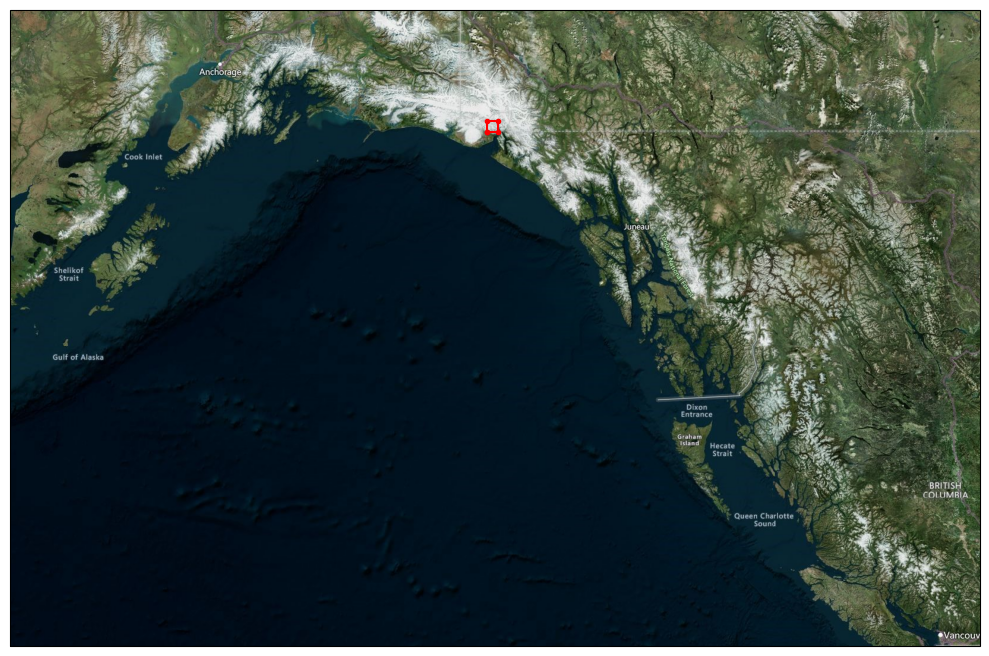

In [91]:
# Visualize the area of interest on a map
cimgt.QuadtreeTiles.get_image = image_spoof # reformat web request for street map spoofing
osm_img = cimgt.QuadtreeTiles() # spoofed, downloaded street map

fig = plt.figure(figsize=(10,10)) # open matplotlib figure
ax1 = plt.axes(projection=osm_img.crs) # project using coordinate reference system (CRS) of street map
center_pt = [55, -139.71] # lat/lon
zoom = 6 # for zooming out of center point
extent = [center_pt[1]-(zoom*3.0),center_pt[1]+(zoom*3.0),center_pt[0]-zoom,center_pt[0]+zoom] # adjust to zoom
ax1.set_extent(extent) # set extents

scale = np.ceil(-np.sqrt(2)*np.log(np.divide(zoom,350.0))) # empirical solve for scale based on zoom
scale = (scale<20) and scale or 19 # scale cannot be larger than 19
ax1.add_image(osm_img, int(scale))

ax1.plot([WEST_LON, WEST_LON, EAST_LON, EAST_LON, WEST_LON], 
         [LOWER_LAT, UPPER_LAT, UPPER_LAT, LOWER_LAT, LOWER_LAT], '.-', 
         c='red', transform=ccrs.PlateCarree())
plt.tight_layout()
plt.show()

## 2) Extract relevant subset of dataset

Relevant variables:
- T2 = Air temperature at 2 meters [$^\circ C$]
- SNOW = Snow Water Equivalent [kg/m^2]
- PCPT = Accumulated total grid scale precipitation[mm]

In [69]:
dates = []; temp_c = []; precip_mm = []; snow_depth_m  = []; swe_kgm2 = [];
for filename in os.listdir(download_path):
    if filename.endswith('.nc'):
        datestr = filename.split('_')[-1][:-3]
        print(datestr)
        file = xr.open_dataset(download_path+filename)

        # grab lat/lon coords
        lats = np.array(file.lat)
        lons = np.array(file.lon)

        # grab the indices associated with spatial bounds
        xidx, yidx = np.where((lats > LOWER_LAT) & (lats < UPPER_LAT) & (lons < EAST_LON) & (lons > WEST_LON))

        # grab temp at 2m
        t2m = np.nanmean(file.T2[:,xidx, yidx]) - 273.15

        # grab precipitation
        precip = np.nanmean(file.PCPT[:,xidx, yidx])

        # swe
        swe = np.nanmean(file.SNOW[:,xidx, yidx])

        # snow depth
        snow_depth = np.nanmean(file.SNOWH[:,xidx, yidx])

        dates.append(datestr); temp_c.append(t2m); precip_mm.append(precip); 
        snow_depth_m.append(snow_depth); swe_kgm2.append(swe)
        
data_df = pd.DataFrame(list(zip(dates, temp_c, precip_mm, snow_depth_m, swe_kgm2)), 
             columns=['date', 't2m_C','precip_mm','snow_depth_m', 'swe_kgm2'])
data_df.date = pd.to_datetime(data_df.date)
data_df

1988-07-26
2017-10-29
2018-07-08
1987-10-07
1982-10-31
1997-11-03
1998-06-22
2005-06-07
2002-01-03
1995-06-29
2015-07-03
2019-07-08
1986-10-07
1989-07-26
2016-10-29
1999-06-22
1983-10-31
1996-11-03
1994-06-29
2004-06-07
2003-01-03
2014-07-03
2006-03-21
2014-05-17
2001-04-25
2013-02-13
2011-05-21
2003-03-17
2016-02-25
2004-04-13
1989-09-25
1999-08-21
2009-04-18
1983-12-25
1986-12-13
2004-08-04
1981-09-18
1988-09-25
1998-08-21
2007-03-21
2015-05-17
2000-04-25
2012-02-13
2010-05-21
2002-03-17
2017-02-25
2005-04-13
1980-09-18
2005-08-04
2008-04-18
1982-12-25
1987-12-13
2019-08-05
2009-09-01
2014-04-19
1996-02-01
1991-05-05
1981-04-01
1986-03-05
2003-02-19
1981-08-16
1994-09-24
1984-08-20
1991-09-12
1996-12-19
2009-05-16
2019-04-12
2003-12-01
1997-02-01
1990-05-05
2015-04-19
2002-02-19
1980-04-01
1987-03-05
2018-08-05
2008-09-01
1997-12-19
2008-05-16
2002-12-01
2018-04-12
1980-08-16
1995-09-24
1985-08-20
1990-09-12
1987-11-09
2018-06-06
2017-11-27
2002-10-15
1988-06-28
2012-11-11
2007-10-23

1988-07-02
2000-06-15
2015-07-27
2007-01-11
1985-07-09
1992-01-09
2005-06-23
2002-01-27
2010-07-11
2009-06-28
1983-10-15
1996-11-27
1999-06-06
2006-11-09
1989-07-02
1986-10-23
1993-11-11
1984-07-09
2001-06-15
2014-07-27
2006-01-11
2004-06-23
2003-01-27
2011-07-11
1993-01-09
1994-04-19
2011-05-05
2016-02-01
2006-03-05
2001-04-01
1983-02-19
1999-08-05
1989-09-01
1989-05-16
2016-12-19
1999-04-12
1983-12-01
2014-09-24
2001-08-16
2011-09-12
2004-08-20
1998-08-05
1988-09-01
2010-05-05
2017-02-01
1995-04-19
1982-02-19
2007-03-05
2000-04-01
2015-09-24
2000-08-16
2010-09-12
2005-08-20
1988-05-16
2017-12-19
1982-12-01
1998-04-12
2013-11-01
2009-07-12
2019-06-16
1986-11-19
2003-10-05
2013-01-19
1991-07-01
1986-01-01
1981-06-05
2004-07-19
2008-07-12
2012-11-01
2002-10-05
2018-06-16
1987-11-19
1990-07-01
2012-01-19
2005-07-19
1987-01-01
1980-06-05
2008-09-11
2018-08-15
1980-04-11
1992-02-27
1987-03-15
1995-05-23
2002-02-09
2015-04-09
1997-02-11
1985-04-27
1990-05-15
1982-03-23
1985-08-30
1990-09-02

2003-09-11
1993-05-28
2004-02-02
2011-03-30
2003-05-06
2013-04-02
2006-05-30
2014-03-06
1984-03-28
2009-12-11
1997-06-30
1982-07-02
1998-11-11
1988-10-15
2002-06-28
1992-06-06
1995-01-02
2008-01-27
2015-10-30
2000-11-02
1998-01-09
2010-10-06
1980-10-28
1999-11-11
1996-06-30
1983-07-02
1993-06-06
1994-01-02
1989-10-15
2003-06-28
2014-10-30
2001-11-02
1999-01-09
2009-01-27
1981-10-28
2011-10-06
2011-12-12
1989-02-19
2014-12-24
1983-09-01
2016-09-19
1993-08-05
1989-12-01
1994-03-16
1986-05-20
1993-04-12
1981-02-24
1983-05-16
1991-03-20
1984-02-12
1996-04-24
1982-09-01
1992-08-05
2017-09-19
2010-12-12
1988-02-19
2015-12-24
1995-03-16
1987-05-20
1992-04-12
1980-02-24
1988-12-01
1982-05-16
1990-03-20
1985-02-12
1997-04-24
2013-08-21
2006-09-13
2016-08-17
2003-09-25
1989-03-17
2001-12-18
1999-02-13
1994-02-18
2011-03-04
2006-05-04
1983-04-18
2009-12-25
1988-03-17
2000-12-18
1998-02-13
2012-08-21
2007-09-13
2017-08-17
2002-09-25
2010-03-04
1995-02-18
1982-04-18
2008-12-25
2007-05-04
2007-07-10

2019-11-10
2009-10-14
1983-06-29
2013-06-07
2014-01-03
2005-11-11
2010-10-23
1990-11-09
2008-01-02
2000-11-27
2015-10-15
1988-10-30
2005-01-09
1995-01-27
1987-07-11
1992-06-23
1982-07-27
1990-01-11
1997-06-15
2012-07-09
2004-11-11
2011-10-23
2001-11-27
2014-10-15
1991-11-09
2009-01-02
1994-01-27
1986-07-11
1993-06-23
1989-10-30
2004-01-09
2013-07-09
1983-07-27
1991-01-11
1996-06-15
1996-04-01
1991-03-05
2014-02-19
2003-04-19
1989-12-24
1981-02-01
1986-05-05
1993-08-20
1986-09-12
1996-08-16
1983-09-24
2009-03-16
2014-12-01
1981-12-19
2019-02-12
2015-02-19
1997-04-01
1990-03-05
1980-02-01
1987-05-05
2002-04-19
1988-12-24
2015-12-01
2008-03-16
1980-12-19
2018-02-12
1992-08-20
1987-09-12
1997-08-16
1982-09-24
2002-04-09
1980-02-11
1992-04-27
1987-05-15
1995-03-23
1997-04-11
1985-02-27
1990-03-15
1982-05-23
2015-02-09
1997-08-06
2007-08-28
1992-08-30
1987-09-02
2010-12-27
2018-02-02
1980-12-09
2008-03-06
2015-12-11
1998-03-28
1981-02-11
1993-04-27
1986-05-15
1994-03-23
2003-04-09
2014-02-09

1984-04-02
2013-03-28
2004-05-28
1986-03-30
1994-05-06
1993-02-02
2018-11-14
1992-07-29
2010-01-31
2002-07-07
2007-07-31
2015-01-07
2012-06-03
1985-01-29
2008-10-10
1980-11-07
1988-01-22
2010-11-29
1990-10-03
2011-01-31
2003-07-07
2019-11-14
1993-07-29
1984-01-29
2009-10-10
2006-07-31
2014-01-07
2013-06-03
1989-01-22
2011-11-29
1981-11-07
1991-10-03
1986-08-18
2003-09-04
1991-12-17
1994-12-21
2019-03-18
2001-02-21
2013-04-17
2006-05-25
2014-03-13
2009-12-04
2016-04-21
2004-02-17
2011-03-25
2003-05-13
1990-12-17
1995-12-21
2018-03-18
2002-09-04
1987-08-18
2008-12-04
2000-02-21
2012-04-17
2007-05-25
2015-03-13
2017-04-21
2005-02-17
2010-03-25
2002-05-13
2009-03-12
2014-12-05
2019-02-16
1986-09-16
1993-08-24
1983-09-20
1996-08-12
1991-03-01
1996-04-05
2013-05-19
1989-12-20
2004-03-19
1986-05-01
1981-02-05
1987-09-16
1992-08-24
1982-09-20
1997-08-12
2015-12-05
2008-03-12
2018-02-16
2012-05-19
1990-03-01
1997-04-05
1987-05-01
1980-02-05
1988-12-20
2005-03-19
2002-06-09
1992-06-27
1995-01-23

2004-01-06
2019-10-11
1994-01-28
1990-10-08
2015-11-14
2000-10-26
2010-11-22
2005-10-10
1988-01-29
2018-01-07
1985-01-22
1997-07-14
1982-06-26
2012-06-08
1992-07-22
1980-01-14
1987-06-10
2014-11-14
2001-10-26
1991-10-08
2019-01-07
2011-11-22
2004-10-10
1989-01-29
2013-06-08
1984-01-22
1996-07-14
1983-06-26
1993-07-22
1981-01-14
1986-06-10
2003-05-18
1986-04-04
1991-02-04
2014-03-18
1999-12-21
2004-12-04
2019-03-13
2009-02-17
1983-08-25
1996-09-17
1986-08-13
1993-09-21
1987-04-04
2002-05-18
2015-03-18
1998-12-21
1990-02-04
1982-08-25
1997-09-17
1987-08-13
1992-09-21
2018-03-13
2005-12-04
2008-02-17
1999-01-17
2011-10-18
1994-11-04
2009-11-21
2001-01-04
2016-07-04
2019-10-25
1993-06-18
1998-01-17
1995-11-04
2010-10-18
2000-01-04
2008-11-21
2018-10-25
1992-06-18
2017-07-04
2017-05-10
2005-03-26
2010-02-14
2002-04-22
1995-03-08
2018-12-31
1982-05-08
2000-03-10
2012-05-26
2007-04-14
2015-02-22
2007-08-03
2017-09-07
1987-09-29
1988-02-07
1980-12-22
1985-12-14
1998-03-03
1994-03-08
2019-12-31

1984-10-10
1991-11-22
1993-06-08
2003-06-26
2004-01-22
2016-07-14
2006-06-10
2013-07-22
2001-01-14
1990-02-14
1982-04-22
1997-05-10
1985-03-26
1998-12-31
2015-03-08
2002-05-08
1987-04-14
1995-02-22
1980-03-10
1992-05-26
2008-02-07
2000-12-22
2005-12-14
2018-03-03
1987-08-03
1997-09-07
2007-09-29
1999-12-31
2014-03-08
1991-02-14
1983-04-22
1996-05-10
1984-03-26
1986-04-14
1994-02-22
1981-03-10
1993-05-26
2003-05-08
1986-08-03
2006-09-29
1996-09-07
2001-12-22
2009-02-07
2019-03-03
2004-12-14
2019-01-17
1991-10-18
2014-11-04
1989-11-21
1981-01-04
1996-07-04
2013-06-18
1999-10-25
2018-01-17
2015-11-04
1990-10-18
1980-01-04
1988-11-21
2012-06-18
1998-10-25
1997-07-04
1981-10-12
1994-11-20
1984-10-24
1991-11-16
2019-10-01
2003-06-12
2004-01-16
2016-07-20
2006-06-24
2013-07-16
2001-01-20
2009-11-05
1980-10-12
1995-11-20
1985-10-24
1990-11-16
2002-06-12
2005-01-16
2017-07-20
2018-10-01
2008-11-05
2007-06-24
2012-07-16
2000-01-20
2012-05-02
2015-02-06
2007-04-30
1985-02-28
2018-12-15
1992-04-28

2019-07-22
1996-11-29
2009-06-26
2006-11-07
1999-06-08
2017-01-15
2005-07-23
2010-06-11
1985-06-09
2000-07-15
2012-01-23
2015-06-27
1988-06-02
1987-11-23
1992-10-11
2008-07-28
1982-11-15
1997-10-27
1998-07-06
2007-10-09
2016-01-15
2004-07-23
2011-06-11
2001-07-15
2013-01-23
2014-06-27
1984-06-09
1986-11-23
1993-10-11
1989-06-02
1999-07-06
2006-10-09
2009-07-28
1983-11-15
1996-10-27
1999-05-12
1989-04-16
1993-12-05
2011-08-12
2004-09-20
2014-08-24
2001-09-16
1983-03-19
2006-02-05
2001-05-01
2011-04-05
2016-03-01
1994-05-19
1989-08-01
1999-09-05
2010-08-12
2005-09-20
2015-08-24
2000-09-16
1998-05-12
1992-12-05
1988-04-16
1988-08-01
1998-09-05
2007-02-05
2000-05-01
1982-03-19
1995-05-19
2010-04-05
2017-03-01
2003-07-18
1989-11-25
1986-06-04
1999-10-21
2014-01-18
2004-10-04
1981-11-18
2019-01-13
1987-06-04
2002-07-18
1988-11-25
1998-10-21
2015-01-18
1980-11-18
2018-01-13
2005-10-04
2017-08-29
1987-08-07
1997-09-03
1982-08-31
1990-12-08
2008-02-03
2000-12-26
1988-03-29
2005-12-10
2018-03-07

1984-07-22
1996-01-14
1991-06-10
2004-06-08
1993-01-22
1981-07-14
1994-06-26
1986-10-18
2019-07-17
2003-11-04
2009-06-13
1981-07-04
2004-06-18
1996-01-04
2002-11-04
1987-10-18
2018-07-17
2008-06-13
2005-06-18
1980-07-04
1997-01-04
2015-05-08
1990-04-14
1982-02-22
1997-03-10
1985-05-26
1987-02-14
1995-04-22
1980-05-10
1992-03-26
2002-03-08
2018-09-14
2008-08-10
2012-12-14
1998-04-29
2008-04-07
2018-05-03
2017-12-22
1980-09-07
2010-09-29
1990-08-03
2019-09-14
2009-08-10
1991-04-14
1983-02-22
1996-03-10
1984-05-26
2014-05-08
2003-03-08
1986-02-14
1994-04-22
1981-05-10
1993-03-26
2011-09-29
1981-09-07
1991-08-03
2009-04-07
2013-12-14
1999-04-29
2016-12-22
2019-05-03
1998-09-30
1985-04-28
2012-03-02
2015-04-06
2005-05-02
2002-02-06
2010-04-30
1992-02-28
2005-09-15
2010-08-27
1980-08-09
2000-09-23
2015-08-11
2008-05-09
1997-12-06
1998-05-27
2007-12-28
1988-04-23
1992-12-30
2013-03-02
2014-04-06
1984-04-28
1993-02-28
2004-05-02
2003-02-06
2011-04-30
1999-09-30
1999-05-27
2006-12-28
2009-05-09

1996-10-06
2009-07-09
1986-11-02
1993-10-30
1989-06-23
2015-07-08
1990-06-14
1985-07-26
1997-01-10
1995-06-22
1992-01-26
1980-07-10
2002-01-08
1998-06-29
2012-10-14
2007-11-26
2008-06-07
1997-11-08
2018-07-03
2017-10-22
2002-11-10
1991-06-14
1984-07-26
1996-01-10
2014-07-08
2003-01-08
1994-06-22
1993-01-26
1981-07-10
2009-06-07
1996-11-08
1999-06-29
2013-10-14
2006-11-26
2016-10-22
2003-11-10
2019-07-03
1984-09-25
1991-08-17
1981-09-13
1994-08-21
2019-05-17
1986-12-18
2009-04-13
2009-08-04
1981-05-04
2004-04-18
2013-02-18
1996-03-04
2018-05-17
1987-12-18
2008-04-13
1985-09-25
1990-08-17
1980-09-13
1995-08-21
2005-04-18
1980-05-04
1997-03-04
2012-02-18
2008-08-04
1983-01-18
1994-07-18
2011-06-04
1999-07-13
1993-10-04
1989-06-17
2016-11-18
1982-01-18
2010-06-04
1995-07-18
1998-07-13
1988-06-17
2017-11-18
1992-10-04
1992-12-10
1988-04-03
1998-05-07
2007-12-08
2008-05-29
1997-12-26
2015-08-31
2000-09-03
1980-08-29
2010-08-07
1992-02-08
2010-04-10
2002-02-26
2017-03-14
2005-05-22
2007-02-10

2006-08-05
2016-09-01
2000-10-20
2015-11-12
2018-01-01
2005-10-16
2010-11-24
1982-06-20
1985-01-24
1997-07-12
2018-11-19
1987-06-16
1992-07-24
1980-01-12
2001-10-20
2014-11-12
2004-10-16
2011-11-24
2019-01-01
1983-06-20
1984-01-24
1996-07-12
2019-11-19
1986-06-16
1993-07-24
1981-01-12
1993-05-30
1981-03-06
1986-04-02
2011-03-28
1999-12-27
2006-05-28
2009-12-09
1984-03-30
1996-05-06
1991-02-02
2019-03-15
2004-12-02
2009-02-11
1996-09-11
1983-08-23
1993-09-27
1986-08-15
2003-09-09
2010-03-28
1992-05-30
1980-03-06
1987-04-02
2008-12-09
1985-03-30
1997-05-06
1990-02-02
1998-12-27
2007-05-28
1997-09-11
1982-08-23
2002-09-09
1992-09-27
1987-08-15
2005-12-02
2018-03-15
2008-02-11
2011-02-26
2003-04-10
2016-05-22
2004-03-14
2019-12-03
1981-02-08
1996-04-08
2006-04-26
2014-02-10
2001-03-22
2013-05-14
2006-08-31
2013-09-03
2003-08-07
1993-08-29
1981-12-10
1984-12-26
2014-12-08
1999-03-31
2018-12-03
1980-02-08
2010-02-26
2002-04-10
2017-05-22
2005-03-14
2007-04-26
2015-02-10
2000-03-22
2012-05-14

2007-07-18
2019-01-25
2001-10-04
1984-11-18
2011-01-18
1989-11-13
1999-10-17
2006-07-18
1983-06-04
1996-05-22
1984-03-14
1991-02-26
1983-04-10
2001-02-08
1999-12-03
2016-04-08
1981-03-22
1993-05-14
1986-04-26
1994-02-10
2001-12-10
2004-12-26
2019-03-31
1994-12-08
1993-09-03
1986-08-31
1983-08-07
2013-08-29
2000-02-08
1998-12-03
1997-05-22
1985-03-14
1990-02-26
1982-04-10
1980-03-22
1992-05-14
1987-04-26
1995-02-10
2017-04-08
1992-09-03
1987-08-31
2012-08-29
1982-08-07
2000-12-10
2018-03-31
1995-12-08
2005-12-26
2013-08-09
1983-08-27
1996-09-15
1986-08-11
1993-09-23
2019-03-11
1994-12-28
2004-12-06
2001-12-30
2009-02-15
1986-04-06
1981-03-02
2016-04-28
2001-02-28
1999-12-23
1983-04-30
1991-02-06
1996-05-02
2005-12-06
2018-03-11
1995-12-28
2008-02-15
2000-12-30
1982-08-27
1997-09-15
2012-08-09
1987-08-11
1992-09-23
2017-04-28
1987-04-06
1980-03-02
1982-04-30
1990-02-06
1997-05-02
2000-02-28
1998-12-23
2008-10-19
1985-01-20
1997-07-16
1982-06-24
1992-07-20
1980-01-16
1987-06-12
2015-11-16

2003-06-24
2004-01-20
2016-07-16
1989-10-19
2006-06-12
2013-07-20
2001-01-16
1981-10-24
1994-11-16
1984-10-12
1991-11-20
1999-01-05
2014-12-28
1999-03-11
1984-12-06
1981-12-30
1989-02-15
1993-08-09
2016-09-15
2003-08-27
2013-09-23
2006-08-11
2001-03-02
2006-04-06
1996-04-28
2019-12-23
1981-02-28
2016-05-02
2003-04-30
2011-02-06
2017-09-15
2002-08-27
1992-08-09
2012-09-23
2007-08-11
1985-12-06
2015-12-28
1998-03-11
1988-02-15
1980-12-30
1997-04-28
2000-03-02
2007-04-06
2017-05-02
2002-04-30
2010-02-06
2018-12-23
1980-02-28
2003-09-29
1993-09-07
1983-08-03
2001-12-14
2004-12-22
2009-12-29
1991-02-22
1983-04-14
1996-05-26
1984-03-10
1999-12-07
2006-05-08
2011-03-08
1986-04-22
1994-02-14
1981-03-26
1993-05-10
2000-12-14
2005-12-22
1992-09-07
2002-09-29
1982-08-03
1998-12-07
2007-05-08
2008-12-29
1990-02-22
1982-04-14
1997-05-26
1985-03-10
1987-04-22
1995-02-14
1980-03-26
1992-05-10
2010-03-08
1988-11-17
2017-06-18
1992-07-04
1985-01-04
1998-10-13
2010-11-04
2018-01-21
1995-10-18
1993-07-04

1991-08-31
1988-09-08
2018-09-26
2008-08-22
1997-03-22
1985-05-14
1990-04-26
1982-02-10
2000-04-08
2017-02-08
1980-05-22
1992-03-14
1987-02-26
1995-04-10
2005-08-29
1995-08-07
1985-09-03
1990-08-31
1982-12-08
2012-12-26
2017-12-10
2018-05-31
2018-07-25
1992-11-18
2017-10-04
2008-06-21
1995-06-04
2010-07-18
2007-01-18
2016-10-04
2019-07-25
1993-11-18
2009-06-21
2011-07-18
1994-06-04
2006-01-18
2008-09-18
2012-03-04
1997-02-18
1980-04-18
2005-05-04
2010-08-21
2005-09-13
2015-08-17
2000-09-25
1998-05-21
1988-04-25
2002-12-18
1996-02-18
2013-03-04
2004-05-04
1981-04-18
2009-09-18
1999-05-21
1989-04-25
2003-12-18
2011-08-21
2004-09-13
2014-08-17
2001-09-25
1986-11-10
1993-10-22
2013-11-08
1983-11-26
1996-10-14
1986-01-08
2004-07-10
2016-01-26
2011-06-22
2013-01-10
2001-07-26
2014-06-14
1991-07-08
1987-11-10
1992-10-22
1982-11-26
1997-10-14
2012-11-08
2005-07-10
2017-01-26
2010-06-22
1987-01-08
1990-07-08
2012-01-10
2000-07-26
2015-06-14
2016-10-30
2003-11-02
2019-07-11
1983-10-28
2009-06-15

1989-09-28
2019-09-06
2016-02-28
1994-04-30
1986-02-06
1981-05-02
1991-04-06
1996-03-02
2001-04-28
2018-05-11
2017-12-30
2012-12-06
2008-04-15
1982-12-28
1990-08-11
1985-09-23
1995-08-27
1980-09-15
2005-08-09
1995-04-30
1987-02-06
1980-05-02
2017-02-28
2000-04-28
1990-04-06
1997-03-02
2008-08-02
2018-09-06
1988-09-28
1993-12-22
1996-12-14
2014-08-03
1994-09-29
2004-09-07
1986-03-08
2016-03-26
2004-05-10
2011-04-22
2003-02-14
2001-05-26
2013-03-10
2006-02-22
2014-04-14
1991-05-08
1999-09-22
2019-08-08
1989-08-26
2015-08-03
2005-09-07
1995-09-29
1992-12-22
1997-12-14
1998-09-22
1988-08-26
2018-08-08
2017-03-26
2005-05-10
2010-04-22
2002-02-14
1987-03-08
1990-05-08
2000-05-26
2012-03-10
2007-02-22
2015-04-14
2012-01-04
1980-06-18
2005-07-04
1998-07-21
1987-11-04
2002-10-18
1988-06-25
2013-01-04
2004-07-04
1981-06-18
1999-07-21
2003-10-18
1989-06-25
1986-11-04
1981-06-08
2011-06-26
2004-07-14
2016-01-22
2014-06-10
2013-01-14
2001-07-22
1993-10-26
1986-11-14
2003-10-08
1999-07-31
1996-10-10

2015-05-11
2017-02-23
2005-04-15
2010-05-27
2002-03-11
1980-05-09
2005-08-02
2010-09-30
1985-09-28
2015-09-06
1982-12-23
1998-04-30
1987-12-15
1994-11-08
2011-10-14
2004-11-26
2014-10-22
2001-11-10
1993-06-14
1986-07-26
1994-01-10
2019-10-29
2016-07-08
1989-10-07
1999-11-03
2001-01-08
1996-06-22
1991-01-26
1983-07-10
2010-10-14
2005-11-26
1995-11-08
2015-10-22
2000-11-10
2017-07-08
1988-10-07
1992-06-14
1987-07-26
1995-01-10
2018-10-29
1997-06-22
1990-01-26
1982-07-10
1998-11-03
2000-01-08
2007-04-18
1982-05-04
1995-03-04
1988-12-13
2010-02-18
1987-09-25
1992-08-17
1982-09-13
1997-08-21
1985-12-18
2008-03-21
2018-02-25
1983-05-04
2006-04-18
1989-12-13
2011-02-18
1994-03-04
1984-12-18
2009-03-21
2019-02-25
1986-09-25
1993-08-17
1983-09-13
1996-08-21
1998-12-19
2012-04-24
2000-02-12
2015-03-20
2007-05-16
2005-02-24
2017-04-12
2002-05-20
2010-03-16
1990-12-24
1998-02-01
1988-03-05
1995-12-12
2017-08-05
1992-09-19
2007-09-01
1999-12-19
2013-04-24
2001-02-12
2014-03-20
2006-05-16
2004-02-24

2000-05-29
1997-02-03
1982-03-31
1990-05-07
1980-04-03
1995-05-31
1987-03-07
2017-03-29
1994-08-28
2004-08-06
2014-09-02
2001-08-30
2013-12-09
1983-12-27
1986-12-11
1989-05-30
2019-09-09
1989-09-27
1999-08-23
2006-03-23
2014-05-15
2001-04-27
2013-02-11
1991-04-09
1986-02-09
2011-05-23
2003-03-15
2016-02-27
2004-04-11
1982-12-27
2012-12-09
1988-05-30
1987-12-11
2005-08-06
1995-08-28
2015-09-02
2000-08-30
1990-04-09
2007-03-23
2015-05-15
2000-04-27
2012-02-11
2010-05-23
2002-03-15
2017-02-27
2005-04-11
1987-02-09
1988-09-27
2018-09-09
1998-08-23
1980-07-19
2005-06-05
2002-01-01
2015-07-01
1997-01-19
1987-10-05
1988-07-24
2002-11-19
1998-06-20
1997-11-01
2004-06-05
2003-01-01
1981-07-19
1996-01-19
2014-07-01
1989-07-24
2003-11-19
1986-10-05
1996-11-01
1999-06-20
2007-12-01
2008-05-20
2018-04-24
1992-12-19
1980-08-20
1995-09-12
1985-08-16
1990-09-24
2007-02-19
1985-04-01
1982-03-05
1992-02-01
1995-05-05
2010-04-19
1998-09-19
1981-08-20
1994-09-12
1984-08-16
1991-09-24
2009-05-20
2006-12-01

1995-05-15
1997-02-27
1985-04-11
1990-05-23
1982-03-15
2007-02-09
2001-06-23
2014-07-11
2006-01-27
1996-01-09
1981-07-09
2004-06-15
2003-01-11
2011-07-27
1999-06-30
1983-10-23
1996-11-11
1986-10-15
1993-11-27
2003-11-09
1997-01-09
2000-06-23
2015-07-11
2007-01-27
2005-06-15
2002-01-11
2010-07-27
1980-07-09
1982-10-23
1997-11-11
1998-06-30
2002-11-09
1987-10-15
1992-11-27
2015-09-12
2000-08-20
2010-09-24
2005-08-16
1987-12-01
1988-05-20
2012-12-19
1998-04-24
2018-09-19
1987-02-19
2002-03-05
2005-04-01
2015-05-05
2012-02-01
1990-04-19
1989-05-20
1986-12-01
2013-12-19
1999-04-24
2014-09-12
2001-08-20
2011-09-24
2004-08-16
2003-03-05
2004-04-01
1986-02-19
1991-04-19
2014-05-05
2013-02-01
2019-09-19
2002-12-13
2008-05-04
2007-12-25
2005-09-18
1980-08-04
1980-04-13
1992-02-25
1987-03-17
1995-05-21
1997-02-13
1985-04-25
1990-05-17
1982-03-21
2008-09-13
2018-08-17
1981-08-04
2004-09-18
2003-12-13
2006-12-25
2009-05-04
2009-09-13
2019-08-17
1981-04-13
1993-02-25
1986-03-17
1994-05-21
1996-02-13

2002-08-18
2018-02-04
2010-12-21
2015-12-17
1986-05-13
1994-03-25
1981-02-17
1993-04-21
1991-03-13
1983-05-25
1996-04-17
1984-02-21
2011-12-21
2019-02-04
2014-12-17
2003-08-18
1986-09-04
2014-10-03
2009-01-14
1994-11-29
2004-11-07
2001-01-29
1999-11-22
1996-06-03
1991-01-07
1983-07-31
2019-10-08
1986-07-07
1994-01-31
1989-10-26
2016-07-29
2008-01-14
2015-10-03
2005-11-07
1995-11-29
1997-06-03
1990-01-07
1982-07-31
2000-01-29
1998-11-22
1988-10-26
2017-07-29
2018-10-08
1987-07-07
1995-01-31
1981-05-28
2016-02-02
2011-05-06
2003-03-30
2001-04-02
2006-03-06
2014-05-30
1996-03-28
1999-08-06
2009-08-28
1989-09-02
1989-05-15
1999-04-11
1983-12-02
2001-08-15
2014-09-27
1984-09-09
2004-08-23
2011-09-11
2008-08-28
1998-08-06
1988-09-02
2017-02-02
2010-05-06
2002-03-30
1980-05-28
1997-03-28
2000-04-02
2007-03-06
2015-05-30
1985-09-09
2000-08-15
2015-09-27
2005-08-23
2010-09-11
1988-05-15
1982-12-02
1998-04-11
1998-06-05
1997-11-24
1982-10-16
1992-11-12
1987-10-20
1988-07-01
2007-01-12
2015-07-24

2013-08-16
2003-09-12
2016-08-20
1986-04-19
2003-05-05
2004-02-01
2014-03-05
2013-04-01
2009-12-12
1991-02-19
1996-07-09
2009-10-06
2013-06-15
2014-01-11
2006-07-27
1999-10-28
2016-06-23
2003-07-11
2011-01-27
2019-11-02
1981-01-09
1991-10-15
1984-11-27
2014-11-09
1994-10-23
1981-11-11
2012-06-15
2015-01-11
2007-07-27
1998-10-28
1997-07-09
2008-10-06
2018-11-02
1980-01-09
2017-06-23
2002-07-11
2010-01-27
2015-11-09
1990-10-15
1985-11-27
1995-10-23
1980-11-11
1999-11-26
2006-06-29
2009-11-08
1991-01-03
1996-06-07
1986-07-03
1989-10-22
2014-10-07
2009-01-10
1984-10-29
2004-11-03
2011-10-31
2008-11-08
1990-01-03
1997-06-07
1998-11-26
2007-06-29
1988-10-22
1987-07-03
2008-01-10
1985-10-29
2015-10-07
2005-11-03
2010-10-31
2010-12-25
2015-12-13
2008-03-04
2012-09-18
1997-08-04
2018-12-18
1980-02-13
1992-04-25
1987-05-17
1995-03-21
1997-04-13
1985-02-25
1990-03-17
1982-05-21
1996-08-04
2013-09-18
2011-12-25
2009-03-04
2014-12-13
2019-12-18
1981-02-13
1993-04-25
1986-05-17
1994-03-21
1996-04-13

,date,t2m_C,precip_mm,snow_depth_m,swe_kgm2
0,1988-07-26,2.472772,8.637370,1.615881,815.459167
1,2017-10-29,0.100793,0.000000,2.537174,910.296814
2,2018-07-08,3.936182,0.000000,2.209873,1114.875000
3,1987-10-07,-5.047583,0.000000,2.081411,755.864990
4,1982-10-31,-11.400336,0.076042,2.154724,708.266479
...,...,...,...,...,...
14595,2011-06-18,3.454431,0.000000,2.436124,1229.947632
14596,2009-07-21,2.706354,2.376042,1.130626,582.339661
14597,2019-06-25,5.675348,0.000000,2.395311,1165.282593
14598,1993-10-18,-6.309088,14.058724,1.572866,448.296906


## 3) Plot the climate variables:

In [81]:
data_df = data_df.sort_values(by='date') # sort by date
avg_data_df = data_df.groupby(pd.Grouper(key='date', freq='Y')).mean() # avg by year
sum_data_df = data_df.groupby(pd.Grouper(key='date', freq='Y')).sum() # sum by year
avg_data_df.head()

,t2m_C,precip_mm,snow_depth_m,swe_kgm2
date,,,,
1980-12-31,-3.286520,12.868736,2.415067,960.033020
1981-12-31,-2.637217,20.021450,2.706226,1087.546875
1982-12-31,-3.858226,10.942581,2.550328,1050.477417
1983-12-31,-2.694754,12.715570,2.686957,1085.833618
1984-12-31,-2.978351,13.986094,2.737536,1094.315430


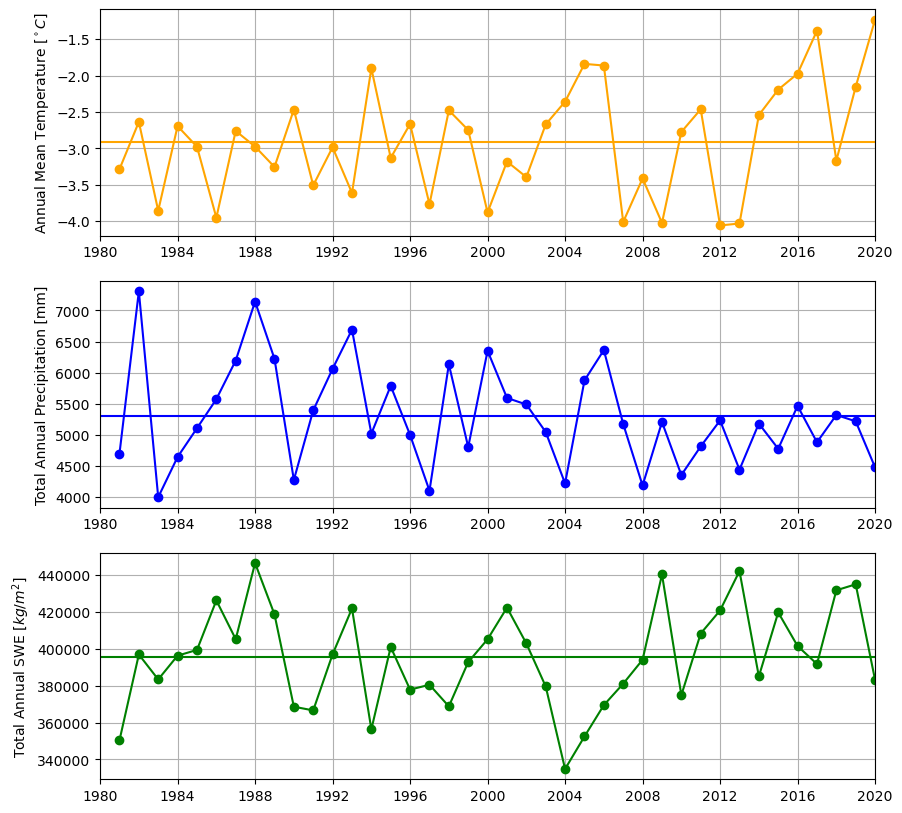

In [83]:
fig, axs = plt.subplots(3,1,figsize=(10,10))

# Temperature
axs[0].plot(avg_data_df.index, avg_data_df.t2m_C, 'o-', color='orange')
axs[0].set_ylabel('Annual Mean Temperature [$^\circ C$]')
axs[0].axhline(y=np.nanmean(avg_data_df.t2m_C), color='orange') # plot mean 
# Precipitation
axs[1].plot(sum_data_df.index, sum_data_df.precip_mm, 'o-', color='blue')
axs[1].set_ylabel('Total Annual Precipitation [mm]');
axs[1].axhline(y=np.nanmean(sum_data_df.precip_mm), color='blue') # plot mean 
# SWE
axs[2].plot(sum_data_df.index, sum_data_df.swe_kgm2,'o-', color='green')
axs[2].set_ylabel('Total Annual SWE [$kg/m^2$]')
axs[2].axhline(y=np.nanmean(sum_data_df.swe_kgm2), color='green') # plot mean

for ax in axs:
    ax.grid('x')
    ax.set_xlim(datetime.datetime(1980,1,1), datetime.datetime(2020,1,1))
plt.show()